In [ ]:
!pip install --quiet einops

In [ ]:
import os
import torch
import sys
import random
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

import torch.nn as nn
from torch import optim

import time
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import io
from scipy import stats

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
sys.path.append('/content/drive/MyDrive/IP/Repos/HFTransformer/FEDformer_Autoformer')

from utils.timefeatures import time_features
from models import FEDformer, Autoformer
from utils.metrics import metric

In [ ]:
class DatasetCustom(Dataset):
    def __init__(self, df, flag='train', size = None, features='MS', target='price', scale=True, timeenc=1, freq='s', diff=False, LAG=0):
        super().__init__()
        self.seq_len, self.label_len, self.pred_len  = size[0], size[1], size[2]
        assert flag in ['train', 'test', 'val', 'pred']
        type_map = {'train': 0, 'val': 1, 'test': 2, 'pred': 3}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq
        self.LAG = LAG

        self.__get_data__(df)

    def __get_data__(self, df):
        self.scaler = StandardScaler()
        df_raw = df.copy()
        cols = list(df_raw.columns)
        cols.remove(self.target)
        cols.remove('datetime')
        df_raw = df_raw[['datetime'] + cols + [self.target]]

        num_train = int(len(df_raw) * 0.8)
        if self.set_type == 0:
            border1, border2 = 0, num_train-self.seq_len
        elif self.set_type == 1:
            border1, border2 = num_train, len(df_raw)
        else:
            border1, border2 = 0, len(df_raw)

        if self.features == 'M' or self.features == 'MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_data = df_raw[[self.target]]
        
        data = df_data.values

        df_stamp = df_raw[['datetime']][border1:border2]
        df_stamp['datetime'] = pd.to_datetime(df_stamp.datetime)
        if self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['datetime'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)
        
        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end].copy()
        seq_y = self.data_y[r_begin:r_end].copy()

        if self.LAG > 0:
            r_LAG_end = r_begin + self.label_len + self.LAG
            seq_LAG_y = self.data_y[r_begin:r_LAG_end].copy()
            #target column is at the end 
            window_return = np.log(seq_LAG_y[-1,-1]/seq_x[-1,-1])*10_000
            # print(window_return.shape)
        else:
            #case for sliding return window, not being used
            window_return = np.log(seq_y[:,-1]/seq_x[-1,-1])*10_000
        seq_y_transformed = seq_y.copy()
        std = 1.1*np.sqrt(self.LAG)+self.LAG*0.01
        seq_y_transformed[-1,-1] = window_return/std
        seq_x_median, seq_x_iqr = np.mean(seq_x, axis=0),  np.std(seq_x, axis=0)#np.median(seq_x, axis=0), np.subtract(*np.percentile(seq_x, [75, 25], axis=0)) #np.std(seq_x, axis=0) 
        epsilon = 0.00001 #0.5 for price
        seq_x_iqr += epsilon)
        seq_x_medianized = (seq_x - seq_x_median)/(seq_x_iqr)
        # we don't standardize returns
        seq_x_median[-1], seq_x_iqr[-1] = 0, 1.0
        seq_y_medianized = (seq_y_transformed - seq_x_median)/(seq_x_iqr)
        seq_x_mark = self.data_stamp[s_begin:s_end]
        seq_y_mark = self.data_stamp[r_begin:r_end]
        # print(seq_y_medianized)

        return seq_x_medianized, seq_y_medianized, seq_x_mark, seq_y_mark, seq_x_median, seq_x_iqr, seq_x

    def __len__(self):
        if self.LAG == 0:
            return len(self.data_x) - self.seq_len - self.pred_len + 1
        else:
            return len(self.data_x) - self.seq_len - self.LAG + 1


def data_provider(df, dict_, flag, LAG):
    timeenc = 0 if dict_['embed'] != 'timeF' else 1
    size=[dict_['seq_len'], dict_['label_len'], dict_['pred_len']]
    
    if flag == 'test':
        shuffle_flag = False
        drop_last = True
        batch_size = dict_['batch_size']
        freq = dict_['freq']
    elif flag == 'pred':
        shuffle_flag = False
        drop_last = False
        batch_size = 1
        freq = dict_['freq']
    else:
        shuffle_flag = False
        drop_last = True
        batch_size = dict_['batch_size']
        freq = dict_['freq']

    data_set = DatasetCustom(
        df=df,
        flag=flag,
        size=size,
        features=dict_['features'],
        target=dict_['target'],
        timeenc=timeenc,
        freq=freq,
        LAG=LAG)
    print(flag, len(data_set))
    
    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        shuffle=shuffle_flag,
        num_workers=0,
        drop_last=drop_last)
    return data_set, data_loader


def r_square(true, pred, train, LAG=0):
    repeats = len(true[0])
    if LAG == 0:
        train_mean = np.mean(train, axis=1).reshape(-1,1).repeat(repeats=repeats, axis=1)
    else:
        train_mean = np.mean(np.log(train[:, LAG:]/train[:, :-LAG]) + 1, axis=1).reshape(-1,1).repeat(repeats=repeats, axis=1)
    r2 = 1 - np.sum(np.square(true-pred))/np.sum(np.square(true-train_mean))
    return r2


def strategy_evaluator(true, pred):
    total_buys, total_sells, total_holds = np.sum(true>0), np.sum(true<0), np.sum(true==0)
    total_correct_buys, total_correct_sells, total_correct_holds = 0, 0, 0
    for idx in range(len(true)):
        for jdx in range(len(true[0])):
            if true[idx,jdx] > 0 and pred[idx,jdx] > 0:
                total_correct_buys += 1
            elif true[idx,jdx] < 0 and pred[idx,jdx] < 0:
                total_correct_sells += 1
            elif true[idx,jdx] == 0 and pred[idx,jdx] == 0:
                total_correct_holds += 1
    total_correct_buys_r, total_correct_sells_r, total_correct_holds_r = (total_correct_buys/total_buys),(total_correct_sells/total_sells),(total_correct_holds/total_holds)
    return total_correct_buys_r.round(3), total_correct_sells_r.round(3), total_correct_holds_r.round(3)

In [ ]:
def train(model, train_df, test_df, model_config, plot_forecast, save_path=None, LAG=0):
    train_data, train_loader = data_provider(train_df, model_config, flag='train', LAG=LAG)
    vali_data, vali_loader = data_provider(train_df, model_config, flag='val', LAG=LAG)
    
    train_steps = len(train_loader)

    if model_config['use_amp']:
        scaler = torch.cuda.amp.GradScaler()

    for epoch in range(model_config['train_epochs']):
        iter_count = 0
        train_loss = []

        model.train()
        epoch_time = time.time()
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark, seq_x_median, seq_x_iqr, seq_x) in enumerate(train_loader):
            iter_count += 1
            optimizer.zero_grad()
            batch_x = batch_x.float().to(model_config['device'])

            batch_y = batch_y.float().to(model_config['device'])
            batch_x_mark = batch_x_mark.float().to(model_config['device'])
            batch_y_mark = batch_y_mark.float().to(model_config['device'])

            # decoder input
            dec_inp = torch.zeros_like(batch_y[:, -model_config['pred_len']:, :]).float()
            dec_inp = torch.cat([batch_y[:, :model_config['label_len'], :], dec_inp], dim=1).float().to(model_config['device'])

            # encoder - decoder
            if model_config['use_amp']:
                with torch.cuda.amp.autocast():
                    if model_config['output_attention']:
                        outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                    else:
                        outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

                    f_dim = -1 if model_config['features'] == 'MS' else 0
                    batch_y = batch_y[:, -model_config['pred_len']:, f_dim:].to(model_config['device'])
                    outputs = outputs[:,:,-model_config['c_out']:]
                    loss = criterion(outputs, batch_y)
                    train_loss.append(loss.item())
            else:
                if model_config['output_attention']:
                    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

                f_dim = -1 if model_config['features'] == 'MS' else 0
                batch_y = batch_y[:, -model_config['pred_len']:, f_dim:].to(model_config['device'])
                
                outputs = outputs[:,:,-model_config['c_out']:]
                loss = criterion(outputs, batch_y)
                train_loss.append(loss.item())
                
            if model_config['use_amp']:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25) #0.01
                optimizer.step()

        train_loss = np.average(train_loss)
        vali_loss, preds, trues, src_val_all = validation(model, vali_data, vali_loader, criterion, model_config)

        # print(f'pred {preds.shape}')
        # print(f'src {src_val_all.shape}')

        true_values, forecast_values, src_val_all = trues.cpu(), preds.cpu(), src_val_all.cpu().numpy()

        # print(f'true {true_values.shape}')
        # print(f'forecast {forecast_values.shape}')
        # print(f'step {src_val_all.shape}')

        r2_sklearn = r2_score(true_values.numpy(), forecast_values.numpy())
        
        results = strategy_evaluator(true_values.unsqueeze(0).numpy(), forecast_values.unsqueeze(0).numpy())
        
        if plot_forecast:        
            forecast_values = torch.Tensor(0)
            true_values = torch.Tensor(0)

            for forecast_idx in range(0, len(preds), model_config['pred_len']):
                forecast_values = torch.cat((forecast_values, preds[forecast_idx,:]))
                true_values = torch.cat((true_values, trues[forecast_idx,:]))  

            fig, ax = plt.subplots(1, 1, figsize = (18, 8))
            ax.plot(true_values.view(-1), label='truth', alpha=0.3)
            ax.plot(forecast_values.view(-1), label='forecast', alpha=0.8)
            ax.set_xlim(left=0, right=len(true_values))
            plt.show()

        print("| epoch: {} | train loss: {:.7f} | val loss: {:.7f} | r2 sklearn val: {:.5f} |  b, s, h: {:} |".format(
            epoch + 1, train_loss, vali_loss, np.mean(r2_sklearn), results))

        if save_path:
            results = {
                    'model': model_config['model_name'],
                    'pred_len': model_config['pred_len'],
                    'epoch': epoch+1,
                    'train_loss': train_loss,
                    'val_loss': vali_loss,
                    'r2_val_sklearn': r2_sklearn            
            }

            df = pd.DataFrame([results])
            df.to_csv(save_path, mode='a', header=not os.path.exists(save_path), index=False)
    return model


def validation(model, vali_data, vali_loader, criterion, model_config):
    total_loss = []
    model.eval()
    preds = torch.Tensor(0)
    trues = torch.Tensor(0)
    batch_x_all = torch.Tensor(0)
    with torch.no_grad():
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark, seq_x_median, seq_x_iqr, seq_x) in enumerate(vali_loader):
            #BATCH,INPUT_LEN,FEATURE
            # batch_x_denorm = torch.mul(batch_x[:,:,-model_config['c_out']:].squeeze(), seq_x_iqr[:,-model_config['c_out']:]
            #                            .float()) + seq_x_median[:,-model_config['c_out']:].float()
            batch_x_all = torch.cat((batch_x_all, seq_x[:,:,-model_config['c_out']:].squeeze()))
            
            batch_x = batch_x.float().to(model_config['device'])
            batch_y = batch_y.float()

            batch_x_mark = batch_x_mark.float().to(model_config['device'])
            batch_y_mark = batch_y_mark.float().to(model_config['device'])

            # decoder input
            dec_inp = torch.zeros_like(batch_y[:, -model_config['pred_len']:, :]).float()
            dec_inp = torch.cat([batch_y[:, :model_config['label_len'], :], dec_inp], dim=1).float().to(model_config['device'])
            # encoder - decoder
            if model_config['use_amp']:
                with torch.cuda.amp.autocast():
                    if model_config['output_attention']:
                        outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                    else:
                        outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
            else:
                if model_config['output_attention']:
                    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
            
            f_dim = -1 if model_config['features'] == 'MS' else 0
            batch_y = batch_y[:, -model_config['pred_len']:, f_dim:].to(model_config['device'])

            outputs = outputs[:,:, -model_config['c_out']:]

            # diff_outputs = outputs[:,1:,:]-outputs[:,:-1,:]
            # diff_batch_y = batch_y[:,1:,:]-batch_y[:,:-1,:]

            loss = criterion(outputs, batch_y)

            pred = outputs.detach().cpu().squeeze() 
            true = batch_y.detach().cpu().squeeze()

            # print(pred)
            # print(true)

            # pred = torch.mul(pred, seq_x_iqr[:,-model_config['c_out']:]
            #                  .float()) + seq_x_median[:,-model_config['c_out']:].float()
            # true = torch.mul(true, seq_x_iqr[:,-model_config['c_out']:]
            #                  .float()) + seq_x_median[:,-model_config['c_out']:].float()
            
            preds = torch.cat((preds, pred))
            trues = torch.cat((trues, true))

            # print(f'pred {preds.shape}')
            # print(f'true {trues.shape}')

            total_loss.append(loss.cpu())
    total_loss = np.average(total_loss)
    return total_loss, preds, trues, batch_x_all

In [ ]:
def test(model, test_df, model_config, plot_prediction=False):
    test_data, test_loader = data_provider(test_df, model_config, flag='test')

    preds = torch.Tensor(0)
    trues = torch.Tensor(0)
    src_all = torch.Tensor(0)

    model.eval()
    with torch.no_grad():
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark, seq_x_median, seq_x_iqr, seq_x) in enumerate(test_loader):
            src_all = torch.cat((src_all, seq_x[:,:,-model_config['c_out']:].squeeze()))

            batch_x = batch_x.float().to(model_config['device'])
            batch_y = batch_y.float().to(model_config['device'])

            batch_x_mark = batch_x_mark.float().to(model_config['device'])
            batch_y_mark = batch_y_mark.float().to(model_config['device'])

            # decoder input
            dec_inp = torch.zeros_like(batch_y[:, -model_config['pred_len']:, :]).float()
            dec_inp = torch.cat([batch_y[:, :model_config['label_len'], :], dec_inp], dim=1).float().to(model_config['device'])
            # encoder - decoder
            if model_config['use_amp']:
                with torch.cuda.amp.autocast():
                    if model_config['output_attention']:
                        outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                    else:
                        outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
            else:
                if model_config['output_attention']:
                    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]

                else:
                    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

            f_dim = -1 if model_config['features'] == 'MS' else 0

            batch_y = batch_y[:, -model_config['pred_len']:, f_dim:].to(model_config['device'])
            outputs = outputs.detach().cpu()
            batch_y = batch_y.detach().cpu()

            pred = outputs[:,:, -model_config['c_out']:].squeeze()
            true = batch_y.squeeze() 

            pred = torch.mul(pred, seq_x_iqr[:,-model_config['c_out']:]
                             .float()) + seq_x_median[:,-model_config['c_out']:].float()
            true = torch.mul(true, seq_x_iqr[:,-model_config['c_out']:]
                             .float()) + seq_x_median[:,-model_config['c_out']:].float()

            preds = torch.cat((preds, pred))
            trues = torch.cat((trues, true))
    
    forecast_values = preds[0,:]
    true_values = trues[0,:]

    src_step_all = np.zeros([len(src_all)//model_config['seq_len']+1, model_config['seq_len']])

    idx = 0
    for src_idx in range(model_config['seq_len'], len(src_all), model_config['seq_len']):
        src_step_all[idx,:] = src_all[src_idx,:].numpy().flatten()
        idx += 1

    for forecast_idx in range(model_config['seq_len'], len(preds), model_config['pred_len']):
        forecast_values = torch.vstack((forecast_values, preds[forecast_idx,:]))
        true_values = torch.vstack((true_values, trues[forecast_idx,:]))  

    if plot_prediction:
        fig, ax = plt.subplots(1, 1, figsize = (18, 8))
        ax.plot(true_values.view(-1).numpy()[:-model_config['pred_len']], label='truth', alpha=0.3)
        ax.plot(forecast_values.view(-1).numpy()[model_config['pred_len']:], label='forecast', alpha=0.8)
        ax.set_xlim(left=0, right=len(true_values.view(-1)))
        plt.show()

    # print(f'true {trues.shape}')
    # print(f'forecast {preds.shape}')
    # print(f'step {src_all.shape}')


    r2 = r_square(trues.numpy(), preds.numpy(), src_all.numpy())

    preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
    trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])

    mae, mse, rmse, mape, mspe = metric(trues.view(-1).numpy(), preds.view(-1).numpy())
    print('mse:{}, mae:{}, r2 test:{}'.format(mse, mae, r2))
    return true_values.numpy(), forecast_values.numpy(), src_all.numpy()

## Defining model

In [ ]:
model_config = {'device': 'cuda',
                'use_amp': False, #False
                'train_epochs': 100,
                'version': 'Wavelets',                
                'mode_select': 'random',
                'modes': 64,
                'moving_avg': 24, #24 for price
                'L': 1,
                'base': 'legendre',
                'cross_activation': 'tanh',
                'seq_len': 100, #150
                'label_len': 50, #75
                'pred_len': 30,
                'output_attention': False,
                'enc_in': 42, #44 for price
                'dec_in': 42, #44 for price
                'd_model': 16,
                'embed': 'timeF',
                'embed_type': 1,
                'dropout': 0.25,
                'freq': 's',
                'factor': 3,
                'n_heads': 8,
                'd_ff': 16,
                'e_layers': 2, #2
                'd_layers': 2, #2
                'c_out': 1,
                'activation': 'gelu',
                'wavelet': 0,
                'batch_size': 256, #256 for price
                'data_path': '/content/drive/MyDrive/IP/Repos/HFTransformer/input_data/all/orderbook.csv',
                'features': 'MS',
                'target': 'price', #price
                'scale': False,
                'scaler': 'normal',
                'num_workers': 0,
                'patience': 8
              }

In [ ]:
def augment_trade_data(df, lag, forecast_window=None):
    if forecast_window:
        df['lag_return'] = np.log(df['price'].shift(forecast_window)/df['price'].shift(forecast_window+1))
        return df.iloc[forecast_window+1:,:]
    if lag == 0:
        return df
    else:
        col_name = 'log_lag'+str(lag)+'_price'
        df[col_name] = np.log(df.price) - np.log(df.price).shift(lag)
        return df.iloc[lag:,:]


def normalize_train_test(df_train, df_test, features, scale):
    train_data = df_train[features]#,'quantity']]
    test_data = df_test[features]#,'quantity']]
    return train_data, test_data

In [ ]:
date_train = 'all'
df_train = pd.read_csv(f'/content/drive/MyDrive/IP/Repos/HFTransformer/input_data/{date_train}/orderbook.csv').reset_index()

In [ ]:
df_train['price'] = df_train['w_midprice']

NameError: ignored

In [ ]:
df_train_subset = df_train[2_000_000:2_100_000].copy()
df_test_subset = df_train[2_150_000:2_250_000].copy()

trade = augment_trade_data(df_train_subset, lag=30)
trade_test = augment_trade_data(df_test_subset, lag=30)

In [ ]:
# features = ['datetime','price',
#             'log_returns', 'log_lag25_returns', 'log_lag50_returns',
#             'dollarvol_bid1', 'dollarvol_bid2', 'dollarvol_bid3', 'dollarvol_bid4', 'dollarvol_bid5',
#             'dollarvol_bid6', 'dollarvol_bid7', 'dollarvol_bid8', 'dollarvol_bid9', 'dollarvol_bid10',
#             'dollarvol_ask1', 'dollarvol_ask2', 'dollarvol_ask3', 'dollarvol_ask4', 'dollarvol_ask5',
#             'dollarvol_ask6', 'dollarvol_ask7', 'dollarvol_ask8', 'dollarvol_ask9', 'dollarvol_ask10',]

features = ['datetime', 'price', 'log_returns',
            'log_lag25_returns', 'log_lag50_returns',
            'bid1', 'bidqty1', 'bid2', 'bidqty2', 'bid3', 'bidqty3', 'bid4', 'bidqty4', 'bid5', 'bidqty5',
            'bid6', 'bidqty6', 'bid7', 'bidqty7', 'bid8', 'bidqty8', 'bid9', 'bidqty9', 'bid10', 'bidqty10',
            'ask1', 'askqty1', 'ask2', 'askqty2', 'ask3', 'askqty3', 'ask4', 'askqty4', 'ask5', 'askqty5',
            'ask6', 'askqty6', 'ask7', 'askqty7', 'ask8', 'askqty8', 'ask9', 'askqty9', 'ask10', 'askqty10']

features = ['datetime', 'price',
            'bid1', 'bidqty1', 'bid2', 'bidqty2', 'bid3', 'bidqty3', 'bid4', 'bidqty4', 'bid5', 'bidqty5',
            'bid6', 'bidqty6', 'bid7', 'bidqty7', 'bid8', 'bidqty8', 'bid9', 'bidqty9', 'bid10', 'bidqty10',
            'ask1', 'askqty1', 'ask2', 'askqty2', 'ask3', 'askqty3', 'ask4', 'askqty4', 'ask5', 'askqty5',
            'ask6', 'askqty6', 'ask7', 'askqty7', 'ask8', 'askqty8', 'ask9', 'askqty9', 'ask10', 'askqty10']

# features = ['datetime', 'price_diff', 'price', 'log_lag25_returns', 'log_lag50_returns',
#             'diff_bid1', 'diff_bidqty1', 'diff_bid2', 'diff_bidqty2', 'diff_bid3', 'diff_bidqty3', 'diff_bid4', 'diff_bidqty4', 'diff_bid5', 'diff_bidqty5',
#             'diff_bid6', 'diff_bidqty6', 'diff_bid7', 'diff_bidqty7', 'diff_bid8', 'diff_bidqty8', 'diff_bid9', 'diff_bidqty9', 'diff_bid10', 'diff_bidqty10',
#             'diff_ask1', 'diff_askqty1', 'diff_ask2', 'diff_askqty2', 'diff_ask3', 'diff_askqty3', 'diff_ask4', 'diff_askqty4', 'diff_ask5', 'diff_askqty5',
#             'diff_ask6', 'diff_askqty6', 'diff_ask7', 'diff_askqty7', 'diff_ask8', 'diff_askqty8', 'diff_ask9', 'diff_askqty9', 'diff_ask10', 'diff_askqty10']

train_data, test_data = normalize_train_test(trade, trade_test, features, scale=False)

In [ ]:
# fig, ax = plt.subplots(3, 1, figsize = (18, 12))
# ax[0].plot(df_train_subset.features[1], label='truth')
# ax[1].plot(df_train_subset.features[1][:2000], label='truth')

## Training

In [ ]:
model_dict = {
            'FEDformer': FEDformer,
            'Autoformer': Autoformer}

model = model_dict['FEDformer'].Model(model_config).float().to('cuda')

criterion = nn.MSELoss(reduction='sum') #nn.SmoothL1Loss() for price
optimizer = optim.AdamW(model.parameters(), lr=0.0002)#0.00005

base legendre
base legendre
base legendre
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
enc_modes: 50, dec_modes: 40


RuntimeError: ignored

In [ ]:
trained_model = train(model, train_data, test_data, model_config, plot_forecast=True)

In [ ]:
torch.save(model,'./model.pt')

## Testing

In [ ]:
model = torch.load('/content/drive/MyDrive/IP/Repos/HFTransformer/FEDformer_Autoformer/saved_models/Autoformer_30.pt')

test 2400


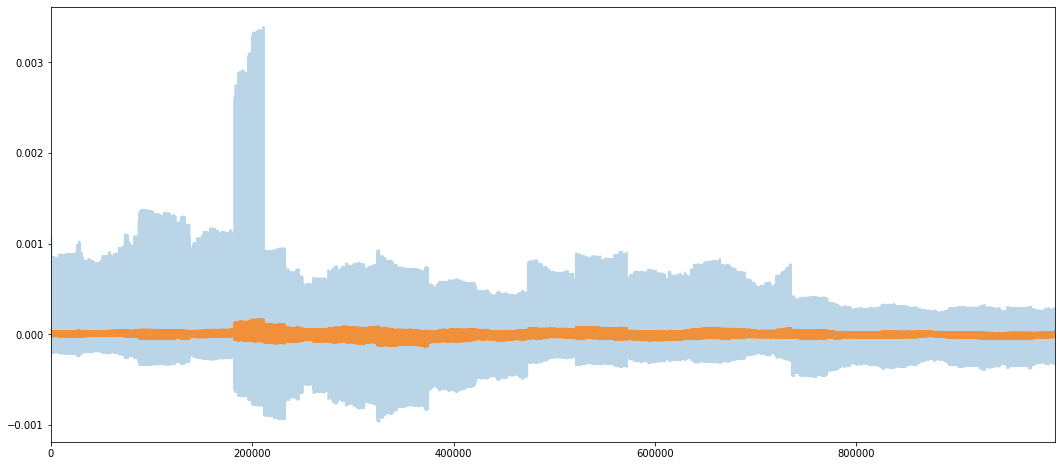

true torch.Size([2048, 512])
forecast torch.Size([2048, 512])
step torch.Size([2048, 100])
mse:6.978654099043524e-09, mae:4.058305421494879e-05, r2 test:-0.026734907883399606


In [ ]:
true, pred, src = test(model, test_data[48_000:50_500], model_config, plot_prediction=True)

In [ ]:
r2_values = r2_score(true, pred, multioutput='raw_values')

In [ ]:
def predict(model, test_df, model_config):
    pred_data, pred_loader = data_provider(test_df, model_config, flag='pred')

    preds = torch.Tensor(0)
    trues = torch.Tensor(0)
    src_all = torch.Tensor(0)

    model.eval()
    with torch.no_grad():
        for i, (batch_x, batch_y, batch_x_mark, batch_y_mark, seq_x_median, seq_x_iqr) in enumerate(pred_loader):
            batch_x = batch_x.float().to(model_config['device'])
            batch_y = batch_y.float()
            batch_x_mark = batch_x_mark.float().to(model_config['device'])
            batch_y_mark = batch_y_mark.float().to(model_config['device'])

            # decoder input
            dec_inp = torch.zeros_like(batch_y[:, -model_config['pred_len']:, :]).float()
            dec_inp = torch.cat([batch_y[:, :model_config['label_len'], :], dec_inp], dim=1).float().to(model_config['device'])
            # encoder - decoder
            
            if model_config['use_amp']:
                with torch.cuda.amp.autocast():
                    if model_config['output_attention']:
                        outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                    else:
                        outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
            else:
                if model_config['output_attention']:
                    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
            
            pred = outputs[:,:, -model_config['c_out']:].squeeze().cpu()
            true = batch_y[:,-model_config['pred_len']:, -model_config['c_out']:].squeeze().cpu()
            src = batch_x[:, :, -model_config['c_out']:].squeeze().cpu()

            pred = torch.mul(pred, seq_x_iqr[:,-model_config['c_out']:]
                             .float()) + seq_x_median[:,-model_config['c_out']:].float()
            true = torch.mul(true, seq_x_iqr[:,-model_config['c_out']:]
                             .float()) + seq_x_median[:,-model_config['c_out']:].float()
            src = torch.mul(src, seq_x_iqr[:,-model_config['c_out']:]
                             .float()) + seq_x_median[:,-model_config['c_out']:].float()

            preds = torch.cat((preds, pred))
            trues = torch.cat((trues, true))
            src_all = torch.cat((src_all, src))

    return preds, trues, src_all

In [ ]:
preds, trues, src_all = predict(model, test_data[80_000:90_000], model_config)

pred 9871


In [ ]:
print(f'r2 sklearn: {r2_score(trues, preds, multioutput="raw_values")}')
r_square(trues.numpy(), preds.numpy(), src_all.numpy())

r2 sklearn: [ 0.56956255  0.56372452  0.55290522  0.53936854  0.52530248  0.50295181
  0.47820774  0.4509278   0.42246517  0.39239192  0.35804179  0.31791111
  0.27641495  0.24643751  0.22449195  0.2058546   0.18459973  0.16225007
  0.13414307  0.10669032  0.07677701  0.04276494  0.00757569 -0.02623167
 -0.05770786 -0.09292938 -0.13291146 -0.17708952 -0.22921504 -0.25207527]


0.3245684504508972

In [ ]:
fig, ax = plt.subplots(4, 4, figsize = (20, 10))
idxs = [idx for idx in range(0, len(preds), model_config['seq_len'])]
rand = np.random.randint(0, len(idxs), size=16)

counter = 0
for i in range(4):
    for j in range(4):
        ax[i][j].plot(np.concatenate([src_all[idxs[rand[counter]]],preds[idxs[rand[counter]]]]))
        ax[i][j].plot(np.concatenate([src_all[idxs[rand[counter]]],trues[idxs[rand[counter]]]]))
        ax[i][j].plot(np.concatenate([src_all[idxs[rand[counter]]],np.mean(src_all[idxs[rand[counter]]].numpy()).repeat(repeats=model_config['pred_len'])]))
        counter += 1


## Optimal paramater search



In [ ]:
date_train = 'all'
date_test = 'all'

df_train = pd.read_csv(f'/content/drive/MyDrive/IP/Repos/HFTransformer/input_data/{date_train}/orderbook.csv').reset_index()

df_train['price'] = df_train['w_midprice']

df_train_subset = df_train[2_000_000:2_030_000].copy()
df_test_subset = df_train[2_150_000:2_250_000].copy()

In [ ]:
save_path = os.path.join('/content/drive/MyDrive/IP/Repos/HFTransformer/FEDformer_Autoformer/results',
                            str(int(time.time()))+'_results.csv')

model_dict = {
            'FEDformer': FEDformer,
            'Autoformer': Autoformer}

model_config['train_epochs'] = 30
model_config['batch_size'] = 512

forecast_windows = [i for i in range(1,31)]
# forecast_windows = [35, 40, 45, 50]

for forecast_window in forecast_windows:
    model_config['pred_len'] = 1
    model_config['target'] = 'price'
    model_config['model_name'] = f'FEDformer_{forecast_window}'

    trade = augment_trade_data(df_train_subset, lag=0, forecast_window=forecast_window)
    trade_test = augment_trade_data(df_test_subset, lag=0, forecast_window=forecast_window)

    features = ['datetime', model_config['target'], 'lag_return',
            'bid1', 'bidqty1', 'bid2', 'bidqty2', 'bid3', 'bidqty3', 'bid4', 'bidqty4', 'bid5', 'bidqty5',
            'bid6', 'bidqty6', 'bid7', 'bidqty7', 'bid8', 'bidqty8', 'bid9', 'bidqty9', 'bid10', 'bidqty10',
            'ask1', 'askqty1', 'ask2', 'askqty2', 'ask3', 'askqty3', 'ask4', 'askqty4', 'ask5', 'askqty5',
            'ask6', 'askqty6', 'ask7', 'askqty7', 'ask8', 'askqty8', 'ask9', 'askqty9', 'ask10', 'askqty10']

    train_data, test_data = normalize_train_test(trade, trade_test, features, scale=False)

    model = model_dict['FEDformer'].Model(model_config).float().to('cuda')
    criterion = nn.MSELoss(reduction='sum')
    optimizer = optim.AdamW(model.parameters(), lr=0.0005) #0.0002 for autoformer

    trained_model = train(model, train_data, test_data, model_config, plot_forecast=False, save_path=save_path, LAG=forecast_window)
    # torch.save(model,f'/content/drive/MyDrive/IP/Repos/HFTransformer/FEDformer_Autoformer/saved_models/Autoformer_LAG_{forecast_window}.pt')
    print(f'Done with prediction len {forecast_window}.')


base legendre
base legendre
base legendre
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
enc_modes: 50, dec_modes: 25
train 23798
val 5900


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 1 | train loss: 685.9737648 | val loss: 517.2802124 | r2 sklearn val: -0.03350 |  b, s, h: (0.298, 0.759, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 2 | train loss: 552.3217044 | val loss: 533.1130371 | r2 sklearn val: -0.06513 |  b, s, h: (0.352, 0.693, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 3 | train loss: 582.1033730 | val loss: 508.7957153 | r2 sklearn val: -0.01655 |  b, s, h: (0.349, 0.705, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 4 | train loss: 503.3132682 | val loss: 503.2910461 | r2 sklearn val: -0.00555 |  b, s, h: (0.599, 0.47, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 5 | train loss: 488.3100699 | val loss: 498.3181458 | r2 sklearn val: 0.00439 |  b, s, h: (0.333, 0.731, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 6 | train loss: 453.2140291 | val loss: 495.9034119 | r2 sklearn val: 0.00921 |  b, s, h: (0.322, 0.754, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 7 | train loss: 437.3643968 | val loss: 494.3576050 | r2 sklearn val: 0.01230 |  b, s, h: (0.351, 0.734, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 8 | train loss: 423.3806262 | val loss: 492.1222839 | r2 sklearn val: 0.01677 |  b, s, h: (0.383, 0.713, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 9 | train loss: 417.3410545 | val loss: 491.8320007 | r2 sklearn val: 0.01735 |  b, s, h: (0.354, 0.733, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 10 | train loss: 413.3880015 | val loss: 490.1960754 | r2 sklearn val: 0.02061 |  b, s, h: (0.392, 0.697, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 11 | train loss: 411.9139766 | val loss: 489.3503723 | r2 sklearn val: 0.02230 |  b, s, h: (0.413, 0.692, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 12 | train loss: 425.8123202 | val loss: 496.3877869 | r2 sklearn val: 0.00824 |  b, s, h: (0.323, 0.755, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 13 | train loss: 420.2198894 | val loss: 490.1312561 | r2 sklearn val: 0.02074 |  b, s, h: (0.416, 0.683, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 14 | train loss: 420.9805938 | val loss: 514.6666870 | r2 sklearn val: -0.02828 |  b, s, h: (0.403, 0.639, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 15 | train loss: 606.6791627 | val loss: 514.9446411 | r2 sklearn val: -0.02883 |  b, s, h: (0.379, 0.655, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 16 | train loss: 488.8322887 | val loss: 500.0145569 | r2 sklearn val: 0.00100 |  b, s, h: (0.66, 0.385, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 17 | train loss: 460.7858485 | val loss: 497.9890442 | r2 sklearn val: 0.00504 |  b, s, h: (0.414, 0.636, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 18 | train loss: 450.1394952 | val loss: 497.2568054 | r2 sklearn val: 0.00651 |  b, s, h: (0.458, 0.608, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 19 | train loss: 438.8441494 | val loss: 498.2839966 | r2 sklearn val: 0.00446 |  b, s, h: (0.377, 0.656, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 20 | train loss: 434.5762342 | val loss: 497.1519775 | r2 sklearn val: 0.00672 |  b, s, h: (0.326, 0.731, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 21 | train loss: 429.2953491 | val loss: 497.4788818 | r2 sklearn val: 0.00606 |  b, s, h: (0.305, 0.753, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 22 | train loss: 426.4878251 | val loss: 496.5503235 | r2 sklearn val: 0.00792 |  b, s, h: (0.28, 0.78, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 23 | train loss: 425.6949290 | val loss: 496.9883118 | r2 sklearn val: 0.00704 |  b, s, h: (0.349, 0.719, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 24 | train loss: 423.5250718 | val loss: 496.0783997 | r2 sklearn val: 0.00886 |  b, s, h: (0.295, 0.761, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 25 | train loss: 418.8190762 | val loss: 497.1303711 | r2 sklearn val: 0.00676 |  b, s, h: (0.298, 0.761, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 26 | train loss: 420.5241596 | val loss: 496.2467957 | r2 sklearn val: 0.00853 |  b, s, h: (0.287, 0.774, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 27 | train loss: 413.4415170 | val loss: 495.3278503 | r2 sklearn val: 0.01036 |  b, s, h: (0.421, 0.662, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 28 | train loss: 414.9019931 | val loss: 495.6276550 | r2 sklearn val: 0.00976 |  b, s, h: (0.507, 0.584, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 29 | train loss: 413.9849160 | val loss: 495.5913391 | r2 sklearn val: 0.00984 |  b, s, h: (0.269, 0.784, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 30 | train loss: 412.5026680 | val loss: 495.0387573 | r2 sklearn val: 0.01094 |  b, s, h: (0.493, 0.594, nan) |
Done with prediction len 1.
base legendre
base legendre
base legendre
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
enc_modes: 50, dec_modes: 25
train 23796
val 5899
| epoch: 1 | train loss: 952.0917033 | val loss: 590.7812500 | r2 sklearn val: -0.10423 |  b, s, h: (0.714, 0.305, 0.0) |
| epoch: 2 | train loss: 596.4123263 | val loss: 555.0471191 | r2 sklearn val: -0.03744 |  b, s, h: (0.612, 0.442, 0.0) |
| epoch: 3 | train loss: 1226.1863456 | val loss: 782.6654053 | r2 sklearn val: -0.46288 |  b, s, h: (0.157, 0.863, 0.0) |
| epoch: 4 | train loss: 1049.1156125 | val loss: 577.5462036 | r2 sklearn val: -0.07949 |  b, s, h: (0.43, 0.618, 0.0) |
| epoch: 5 | train loss: 722.3190002 | val loss: 563.0300293 | r2 sklearn val: -0.05236 |  b, s, h: (0.408, 0.629, 0.0) |
| epoch: 6 | train 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 1 | train loss: 871.4306707 | val loss: 576.7861938 | r2 sklearn val: -0.06617 |  b, s, h: (0.635, 0.384, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 2 | train loss: 617.1089106 | val loss: 571.0847168 | r2 sklearn val: -0.05564 |  b, s, h: (0.472, 0.537, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 3 | train loss: 694.4946415 | val loss: 565.1099854 | r2 sklearn val: -0.04459 |  b, s, h: (0.389, 0.632, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 4 | train loss: 621.8925523 | val loss: 551.7169800 | r2 sklearn val: -0.01983 |  b, s, h: (0.415, 0.631, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 5 | train loss: 588.7866835 | val loss: 576.8871460 | r2 sklearn val: -0.06636 |  b, s, h: (0.593, 0.454, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 6 | train loss: 966.3588098 | val loss: 571.1130371 | r2 sklearn val: -0.05569 |  b, s, h: (0.539, 0.499, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 7 | train loss: 646.0169631 | val loss: 558.6010742 | r2 sklearn val: -0.03256 |  b, s, h: (0.592, 0.431, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 8 | train loss: 560.7341561 | val loss: 549.5829468 | r2 sklearn val: -0.01589 |  b, s, h: (0.577, 0.441, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 9 | train loss: 526.8438090 | val loss: 547.2536621 | r2 sklearn val: -0.01158 |  b, s, h: (0.524, 0.506, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 10 | train loss: 505.3626543 | val loss: 544.1320801 | r2 sklearn val: -0.00581 |  b, s, h: (0.554, 0.484, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 11 | train loss: 504.1955148 | val loss: 544.2434082 | r2 sklearn val: -0.00602 |  b, s, h: (0.611, 0.424, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 12 | train loss: 498.4071317 | val loss: 542.4546509 | r2 sklearn val: -0.00271 |  b, s, h: (0.603, 0.441, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 13 | train loss: 494.7909290 | val loss: 544.7054443 | r2 sklearn val: -0.00687 |  b, s, h: (0.568, 0.472, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 14 | train loss: 494.4571347 | val loss: 542.1796875 | r2 sklearn val: -0.00221 |  b, s, h: (0.624, 0.438, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 15 | train loss: 488.0724328 | val loss: 539.6438599 | r2 sklearn val: 0.00248 |  b, s, h: (0.516, 0.539, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 16 | train loss: 485.9341132 | val loss: 540.4590454 | r2 sklearn val: 0.00098 |  b, s, h: (0.528, 0.524, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 17 | train loss: 480.9344317 | val loss: 538.6211548 | r2 sklearn val: 0.00437 |  b, s, h: (0.447, 0.616, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 18 | train loss: 482.4407740 | val loss: 539.6813965 | r2 sklearn val: 0.00241 |  b, s, h: (0.42, 0.625, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 19 | train loss: 481.5247189 | val loss: 538.1739502 | r2 sklearn val: 0.00520 |  b, s, h: (0.485, 0.58, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 20 | train loss: 478.1859134 | val loss: 538.2197876 | r2 sklearn val: 0.00511 |  b, s, h: (0.428, 0.634, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 21 | train loss: 478.6807868 | val loss: 538.0912476 | r2 sklearn val: 0.00535 |  b, s, h: (0.493, 0.575, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 22 | train loss: 475.7214044 | val loss: 537.6376343 | r2 sklearn val: 0.00619 |  b, s, h: (0.406, 0.651, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 23 | train loss: 473.8843089 | val loss: 537.0594482 | r2 sklearn val: 0.00726 |  b, s, h: (0.457, 0.623, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 24 | train loss: 474.2027303 | val loss: 537.1645508 | r2 sklearn val: 0.00706 |  b, s, h: (0.409, 0.648, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 25 | train loss: 473.5965729 | val loss: 536.8245850 | r2 sklearn val: 0.00769 |  b, s, h: (0.531, 0.549, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 26 | train loss: 474.0373714 | val loss: 538.4373779 | r2 sklearn val: 0.00471 |  b, s, h: (0.417, 0.634, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 27 | train loss: 476.2824601 | val loss: 539.6320801 | r2 sklearn val: 0.00250 |  b, s, h: (0.728, 0.347, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 28 | train loss: 476.1130311 | val loss: 537.9890137 | r2 sklearn val: 0.00554 |  b, s, h: (0.694, 0.388, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 29 | train loss: 475.0258252 | val loss: 537.6118164 | r2 sklearn val: 0.00624 |  b, s, h: (0.677, 0.408, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 30 | train loss: 472.0253492 | val loss: 536.5822754 | r2 sklearn val: 0.00814 |  b, s, h: (0.598, 0.495, nan) |
Done with prediction len 3.
base legendre
base legendre
base legendre
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
enc_modes: 50, dec_modes: 25
train 23793
val 5896


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 1 | train loss: 844.4453430 | val loss: 596.8653564 | r2 sklearn val: -0.09783 |  b, s, h: (0.824, 0.212, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 2 | train loss: 636.0035142 | val loss: 551.0495605 | r2 sklearn val: -0.01356 |  b, s, h: (0.498, 0.556, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 3 | train loss: 617.1342090 | val loss: 554.2203369 | r2 sklearn val: -0.01939 |  b, s, h: (0.485, 0.577, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 4 | train loss: 582.4536226 | val loss: 556.2262573 | r2 sklearn val: -0.02308 |  b, s, h: (0.686, 0.375, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 5 | train loss: 558.1543135 | val loss: 548.5971069 | r2 sklearn val: -0.00905 |  b, s, h: (0.705, 0.375, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 6 | train loss: 546.6070072 | val loss: 543.5772705 | r2 sklearn val: 0.00019 |  b, s, h: (0.422, 0.673, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 7 | train loss: 588.7899495 | val loss: 542.1907349 | r2 sklearn val: 0.00274 |  b, s, h: (0.615, 0.49, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 8 | train loss: 560.5415278 | val loss: 544.6192017 | r2 sklearn val: -0.00173 |  b, s, h: (0.712, 0.382, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 9 | train loss: 535.0133985 | val loss: 546.9321899 | r2 sklearn val: -0.00598 |  b, s, h: (0.555, 0.534, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 10 | train loss: 575.9078913 | val loss: 547.7805176 | r2 sklearn val: -0.00754 |  b, s, h: (0.263, 0.798, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 11 | train loss: 519.0420904 | val loss: 538.0302734 | r2 sklearn val: 0.01039 |  b, s, h: (0.491, 0.614, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 12 | train loss: 503.4471061 | val loss: 538.5344238 | r2 sklearn val: 0.00946 |  b, s, h: (0.345, 0.745, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 13 | train loss: 493.4520430 | val loss: 538.2859497 | r2 sklearn val: 0.00992 |  b, s, h: (0.331, 0.765, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 14 | train loss: 489.6930860 | val loss: 538.9531250 | r2 sklearn val: 0.00869 |  b, s, h: (0.347, 0.749, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 15 | train loss: 520.3046888 | val loss: 552.3059082 | r2 sklearn val: -0.01587 |  b, s, h: (0.667, 0.411, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 16 | train loss: 550.4355436 | val loss: 544.7212524 | r2 sklearn val: -0.00192 |  b, s, h: (0.379, 0.706, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 17 | train loss: 534.0718483 | val loss: 546.4136963 | r2 sklearn val: -0.00503 |  b, s, h: (0.665, 0.409, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 18 | train loss: 531.5646150 | val loss: 548.9392090 | r2 sklearn val: -0.00968 |  b, s, h: (0.233, 0.815, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 19 | train loss: 521.6564868 | val loss: 549.1918945 | r2 sklearn val: -0.01014 |  b, s, h: (0.191, 0.851, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 20 | train loss: 510.2705489 | val loss: 543.0156860 | r2 sklearn val: 0.00122 |  b, s, h: (0.508, 0.564, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 21 | train loss: 500.4360697 | val loss: 542.9841309 | r2 sklearn val: 0.00128 |  b, s, h: (0.404, 0.659, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 22 | train loss: 496.0871506 | val loss: 541.7914429 | r2 sklearn val: 0.00347 |  b, s, h: (0.47, 0.619, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 23 | train loss: 495.3571665 | val loss: 540.2352905 | r2 sklearn val: 0.00633 |  b, s, h: (0.456, 0.64, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 24 | train loss: 489.4906278 | val loss: 541.3173828 | r2 sklearn val: 0.00434 |  b, s, h: (0.335, 0.758, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 25 | train loss: 488.5869034 | val loss: 540.4841309 | r2 sklearn val: 0.00588 |  b, s, h: (0.378, 0.715, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 26 | train loss: 487.1403901 | val loss: 540.5075684 | r2 sklearn val: 0.00583 |  b, s, h: (0.331, 0.761, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 27 | train loss: 485.5320647 | val loss: 540.9745483 | r2 sklearn val: 0.00497 |  b, s, h: (0.359, 0.738, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 28 | train loss: 486.1177199 | val loss: 539.9630127 | r2 sklearn val: 0.00683 |  b, s, h: (0.438, 0.666, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 29 | train loss: 484.1478743 | val loss: 539.6691284 | r2 sklearn val: 0.00738 |  b, s, h: (0.403, 0.693, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 30 | train loss: 483.1651028 | val loss: 540.7235718 | r2 sklearn val: 0.00544 |  b, s, h: (0.336, 0.754, nan) |
Done with prediction len 4.
base legendre
base legendre
base legendre
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
enc_modes: 50, dec_modes: 25
train 23791
val 5895


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 1 | train loss: 1049.3265421 | val loss: 599.2108765 | r2 sklearn val: -0.10394 |  b, s, h: (0.427, 0.578, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 2 | train loss: 830.5018894 | val loss: 576.1530762 | r2 sklearn val: -0.06146 |  b, s, h: (0.497, 0.528, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 3 | train loss: 698.7741606 | val loss: 574.5471191 | r2 sklearn val: -0.05850 |  b, s, h: (0.204, 0.817, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 4 | train loss: 742.2573322 | val loss: 574.8271484 | r2 sklearn val: -0.05902 |  b, s, h: (0.238, 0.787, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 5 | train loss: 721.7648475 | val loss: 592.2183228 | r2 sklearn val: -0.09106 |  b, s, h: (0.433, 0.572, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 6 | train loss: 891.7985057 | val loss: 579.5433350 | r2 sklearn val: -0.06771 |  b, s, h: (0.364, 0.652, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 7 | train loss: 682.4794225 | val loss: 562.6003418 | r2 sklearn val: -0.03649 |  b, s, h: (0.406, 0.615, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 8 | train loss: 735.9202198 | val loss: 579.8964844 | r2 sklearn val: -0.06836 |  b, s, h: (0.527, 0.487, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 9 | train loss: 685.6543022 | val loss: 561.5532837 | r2 sklearn val: -0.03456 |  b, s, h: (0.544, 0.473, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 10 | train loss: 586.7076535 | val loss: 558.0690918 | r2 sklearn val: -0.02815 |  b, s, h: (0.585, 0.434, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 11 | train loss: 564.3094522 | val loss: 554.4052124 | r2 sklearn val: -0.02140 |  b, s, h: (0.592, 0.428, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 12 | train loss: 545.0458732 | val loss: 551.4297485 | r2 sklearn val: -0.01591 |  b, s, h: (0.503, 0.506, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 13 | train loss: 537.5368506 | val loss: 547.9641724 | r2 sklearn val: -0.00953 |  b, s, h: (0.548, 0.476, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 14 | train loss: 531.9531797 | val loss: 546.4670410 | r2 sklearn val: -0.00677 |  b, s, h: (0.492, 0.538, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 15 | train loss: 526.5755847 | val loss: 544.8900146 | r2 sklearn val: -0.00387 |  b, s, h: (0.553, 0.469, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 16 | train loss: 523.5673128 | val loss: 545.0422363 | r2 sklearn val: -0.00415 |  b, s, h: (0.536, 0.498, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 17 | train loss: 519.6400074 | val loss: 543.8541870 | r2 sklearn val: -0.00196 |  b, s, h: (0.559, 0.485, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 18 | train loss: 515.1455499 | val loss: 543.5754395 | r2 sklearn val: -0.00144 |  b, s, h: (0.507, 0.548, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 19 | train loss: 513.3955964 | val loss: 543.5003662 | r2 sklearn val: -0.00131 |  b, s, h: (0.55, 0.505, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 20 | train loss: 510.7914571 | val loss: 543.2770386 | r2 sklearn val: -0.00089 |  b, s, h: (0.446, 0.598, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 21 | train loss: 510.0492919 | val loss: 543.3170776 | r2 sklearn val: -0.00097 |  b, s, h: (0.497, 0.552, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 22 | train loss: 509.7987386 | val loss: 542.5581055 | r2 sklearn val: 0.00043 |  b, s, h: (0.44, 0.613, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 23 | train loss: 508.7406825 | val loss: 542.8293457 | r2 sklearn val: -0.00007 |  b, s, h: (0.486, 0.574, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 24 | train loss: 506.5312686 | val loss: 542.8843384 | r2 sklearn val: -0.00017 |  b, s, h: (0.441, 0.612, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 25 | train loss: 507.3418052 | val loss: 542.3217773 | r2 sklearn val: 0.00087 |  b, s, h: (0.5, 0.569, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 26 | train loss: 506.3034320 | val loss: 542.4673462 | r2 sklearn val: 0.00060 |  b, s, h: (0.462, 0.599, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 27 | train loss: 505.2036302 | val loss: 542.2374268 | r2 sklearn val: 0.00102 |  b, s, h: (0.407, 0.645, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 28 | train loss: 503.7856658 | val loss: 542.1328735 | r2 sklearn val: 0.00121 |  b, s, h: (0.471, 0.608, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 29 | train loss: 504.1700884 | val loss: 542.6271973 | r2 sklearn val: 0.00030 |  b, s, h: (0.554, 0.513, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 30 | train loss: 507.0822097 | val loss: 542.4836426 | r2 sklearn val: 0.00057 |  b, s, h: (0.514, 0.552, nan) |
Done with prediction len 5.
base legendre
base legendre
base legendre
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
enc_modes: 50, dec_modes: 25
train 23789
val 5894


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 1 | train loss: 803.0892659 | val loss: 600.0305786 | r2 sklearn val: -0.10512 |  b, s, h: (0.695, 0.334, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 2 | train loss: 771.3465026 | val loss: 605.8065796 | r2 sklearn val: -0.11576 |  b, s, h: (0.668, 0.357, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 3 | train loss: 905.9060125 | val loss: 591.5520630 | r2 sklearn val: -0.08950 |  b, s, h: (0.74, 0.294, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 4 | train loss: 719.0841078 | val loss: 570.2557983 | r2 sklearn val: -0.05028 |  b, s, h: (0.631, 0.398, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 5 | train loss: 752.3653730 | val loss: 598.8619385 | r2 sklearn val: -0.10297 |  b, s, h: (0.673, 0.36, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 6 | train loss: 751.5089390 | val loss: 562.5243530 | r2 sklearn val: -0.03604 |  b, s, h: (0.74, 0.319, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 7 | train loss: 621.4763024 | val loss: 553.8414307 | r2 sklearn val: -0.02005 |  b, s, h: (0.726, 0.331, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 8 | train loss: 575.2180342 | val loss: 548.3661499 | r2 sklearn val: -0.00997 |  b, s, h: (0.594, 0.469, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 9 | train loss: 559.0436859 | val loss: 546.6690063 | r2 sklearn val: -0.00684 |  b, s, h: (0.66, 0.406, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 10 | train loss: 545.8684779 | val loss: 545.9912109 | r2 sklearn val: -0.00559 |  b, s, h: (0.581, 0.471, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 11 | train loss: 540.3135369 | val loss: 544.1543579 | r2 sklearn val: -0.00221 |  b, s, h: (0.581, 0.481, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 12 | train loss: 531.8500376 | val loss: 544.0021362 | r2 sklearn val: -0.00193 |  b, s, h: (0.561, 0.501, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 13 | train loss: 526.1792297 | val loss: 543.9769897 | r2 sklearn val: -0.00188 |  b, s, h: (0.665, 0.413, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 14 | train loss: 523.8627535 | val loss: 543.5067749 | r2 sklearn val: -0.00102 |  b, s, h: (0.579, 0.491, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 15 | train loss: 520.9422607 | val loss: 543.0439453 | r2 sklearn val: -0.00016 |  b, s, h: (0.615, 0.451, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 16 | train loss: 517.5860805 | val loss: 543.4378662 | r2 sklearn val: -0.00089 |  b, s, h: (0.605, 0.455, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 17 | train loss: 519.4977105 | val loss: 543.1159668 | r2 sklearn val: -0.00030 |  b, s, h: (0.541, 0.526, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 18 | train loss: 514.7028324 | val loss: 542.7481079 | r2 sklearn val: 0.00038 |  b, s, h: (0.487, 0.585, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 19 | train loss: 515.4389715 | val loss: 542.8034058 | r2 sklearn val: 0.00028 |  b, s, h: (0.501, 0.569, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 20 | train loss: 513.4636808 | val loss: 543.5611572 | r2 sklearn val: -0.00112 |  b, s, h: (0.639, 0.428, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 21 | train loss: 513.7663116 | val loss: 543.0321655 | r2 sklearn val: -0.00014 |  b, s, h: (0.519, 0.553, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 22 | train loss: 511.1160006 | val loss: 543.5057983 | r2 sklearn val: -0.00101 |  b, s, h: (0.647, 0.415, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 23 | train loss: 509.8385932 | val loss: 544.1036377 | r2 sklearn val: -0.00212 |  b, s, h: (0.759, 0.294, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 24 | train loss: 510.7615751 | val loss: 545.2002563 | r2 sklearn val: -0.00414 |  b, s, h: (0.807, 0.236, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 25 | train loss: 510.1346051 | val loss: 547.6076660 | r2 sklearn val: -0.00857 |  b, s, h: (0.654, 0.393, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 26 | train loss: 519.9739274 | val loss: 547.7744751 | r2 sklearn val: -0.00888 |  b, s, h: (0.436, 0.614, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 27 | train loss: 548.5334901 | val loss: 543.3560181 | r2 sklearn val: -0.00074 |  b, s, h: (0.355, 0.687, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 28 | train loss: 536.0244220 | val loss: 542.7023926 | r2 sklearn val: 0.00047 |  b, s, h: (0.4, 0.664, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 29 | train loss: 528.8085025 | val loss: 540.4768066 | r2 sklearn val: 0.00456 |  b, s, h: (0.531, 0.529, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 30 | train loss: 521.8395512 | val loss: 541.6119385 | r2 sklearn val: 0.00247 |  b, s, h: (0.634, 0.43, nan) |
Done with prediction len 6.
base legendre
base legendre
base legendre
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
enc_modes: 50, dec_modes: 25
train 23787
val 5893


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 1 | train loss: 869.8108136 | val loss: 575.8095703 | r2 sklearn val: -0.06763 |  b, s, h: (0.543, 0.473, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 2 | train loss: 702.6796358 | val loss: 589.2975464 | r2 sklearn val: -0.09264 |  b, s, h: (0.173, 0.82, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 3 | train loss: 630.2635226 | val loss: 554.1808472 | r2 sklearn val: -0.02753 |  b, s, h: (0.393, 0.635, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 4 | train loss: 633.3639732 | val loss: 574.0928345 | r2 sklearn val: -0.06445 |  b, s, h: (0.224, 0.786, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 5 | train loss: 1034.0336450 | val loss: 584.9090576 | r2 sklearn val: -0.08451 |  b, s, h: (0.344, 0.66, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 6 | train loss: 699.4494569 | val loss: 560.9017334 | r2 sklearn val: -0.03999 |  b, s, h: (0.299, 0.725, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 7 | train loss: 616.2746018 | val loss: 554.0567017 | r2 sklearn val: -0.02730 |  b, s, h: (0.271, 0.754, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 8 | train loss: 589.3908307 | val loss: 558.8676147 | r2 sklearn val: -0.03622 |  b, s, h: (0.137, 0.872, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 9 | train loss: 568.0510785 | val loss: 550.2382202 | r2 sklearn val: -0.02022 |  b, s, h: (0.177, 0.836, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 10 | train loss: 548.6400418 | val loss: 548.4920654 | r2 sklearn val: -0.01698 |  b, s, h: (0.143, 0.869, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 11 | train loss: 539.2259661 | val loss: 543.7925415 | r2 sklearn val: -0.00827 |  b, s, h: (0.262, 0.756, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 12 | train loss: 541.9948123 | val loss: 539.7824097 | r2 sklearn val: -0.00084 |  b, s, h: (0.557, 0.479, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 13 | train loss: 534.3043505 | val loss: 539.3527832 | r2 sklearn val: -0.00004 |  b, s, h: (0.671, 0.391, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 14 | train loss: 528.0260507 | val loss: 539.1284790 | r2 sklearn val: 0.00038 |  b, s, h: (0.702, 0.354, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 15 | train loss: 523.5028640 | val loss: 538.7715454 | r2 sklearn val: 0.00104 |  b, s, h: (0.707, 0.342, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 16 | train loss: 521.4602336 | val loss: 538.5347290 | r2 sklearn val: 0.00148 |  b, s, h: (0.481, 0.556, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 17 | train loss: 524.3598527 | val loss: 537.6502075 | r2 sklearn val: 0.00312 |  b, s, h: (0.618, 0.436, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 18 | train loss: 521.5958063 | val loss: 539.2799072 | r2 sklearn val: 0.00010 |  b, s, h: (0.708, 0.346, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 19 | train loss: 518.4596007 | val loss: 538.5962524 | r2 sklearn val: 0.00136 |  b, s, h: (0.728, 0.329, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 20 | train loss: 516.2953521 | val loss: 538.1749268 | r2 sklearn val: 0.00215 |  b, s, h: (0.716, 0.347, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 21 | train loss: 519.9409412 | val loss: 540.2117920 | r2 sklearn val: -0.00163 |  b, s, h: (0.235, 0.763, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 22 | train loss: 521.3766652 | val loss: 540.7525024 | r2 sklearn val: -0.00263 |  b, s, h: (0.173, 0.842, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 23 | train loss: 517.4352954 | val loss: 537.5342407 | r2 sklearn val: 0.00333 |  b, s, h: (0.444, 0.608, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 24 | train loss: 519.1738882 | val loss: 539.3607178 | r2 sklearn val: -0.00005 |  b, s, h: (0.185, 0.844, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 25 | train loss: 520.0658407 | val loss: 539.0770874 | r2 sklearn val: 0.00047 |  b, s, h: (0.254, 0.782, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 26 | train loss: 518.1920073 | val loss: 538.3432007 | r2 sklearn val: 0.00183 |  b, s, h: (0.512, 0.532, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 27 | train loss: 516.9683685 | val loss: 540.4398804 | r2 sklearn val: -0.00205 |  b, s, h: (0.854, 0.192, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 28 | train loss: 517.5538058 | val loss: 539.1430054 | r2 sklearn val: 0.00035 |  b, s, h: (0.751, 0.29, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 29 | train loss: 514.0048490 | val loss: 540.3635254 | r2 sklearn val: -0.00191 |  b, s, h: (0.876, 0.172, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 30 | train loss: 513.6685058 | val loss: 539.3482056 | r2 sklearn val: -0.00003 |  b, s, h: (0.836, 0.217, nan) |
Done with prediction len 7.
base legendre
base legendre
base legendre
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
enc_modes: 50, dec_modes: 25
train 23785
val 5892


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 1 | train loss: 813.9815621 | val loss: 570.4384766 | r2 sklearn val: -0.07493 |  b, s, h: (0.669, 0.355, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 2 | train loss: 709.3776199 | val loss: 555.4282227 | r2 sklearn val: -0.04665 |  b, s, h: (0.483, 0.54, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 3 | train loss: 679.8256292 | val loss: 550.2663574 | r2 sklearn val: -0.03692 |  b, s, h: (0.629, 0.402, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 4 | train loss: 633.8722979 | val loss: 552.8312378 | r2 sklearn val: -0.04175 |  b, s, h: (0.722, 0.311, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 5 | train loss: 631.2822339 | val loss: 548.8894043 | r2 sklearn val: -0.03433 |  b, s, h: (0.746, 0.288, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 6 | train loss: 598.0672143 | val loss: 545.5615845 | r2 sklearn val: -0.02805 |  b, s, h: (0.73, 0.32, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 7 | train loss: 596.4300584 | val loss: 544.6044922 | r2 sklearn val: -0.02625 |  b, s, h: (0.808, 0.227, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 8 | train loss: 589.0654761 | val loss: 548.3007812 | r2 sklearn val: -0.03322 |  b, s, h: (0.579, 0.451, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 9 | train loss: 583.9698304 | val loss: 539.9578247 | r2 sklearn val: -0.01749 |  b, s, h: (0.692, 0.348, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 10 | train loss: 556.0503122 | val loss: 540.4271851 | r2 sklearn val: -0.01838 |  b, s, h: (0.728, 0.308, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 11 | train loss: 570.9310256 | val loss: 541.7850952 | r2 sklearn val: -0.02094 |  b, s, h: (0.68, 0.356, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 12 | train loss: 637.2727800 | val loss: 541.8355713 | r2 sklearn val: -0.02103 |  b, s, h: (0.621, 0.407, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 13 | train loss: 570.2212856 | val loss: 536.5242920 | r2 sklearn val: -0.01102 |  b, s, h: (0.545, 0.472, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 14 | train loss: 544.9589622 | val loss: 535.0674438 | r2 sklearn val: -0.00828 |  b, s, h: (0.689, 0.359, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 15 | train loss: 537.7054676 | val loss: 535.2147217 | r2 sklearn val: -0.00856 |  b, s, h: (0.624, 0.401, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 16 | train loss: 532.7200400 | val loss: 533.1484985 | r2 sklearn val: -0.00466 |  b, s, h: (0.533, 0.502, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 17 | train loss: 528.9020983 | val loss: 534.2210693 | r2 sklearn val: -0.00668 |  b, s, h: (0.451, 0.589, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 18 | train loss: 527.9263564 | val loss: 534.5512085 | r2 sklearn val: -0.00731 |  b, s, h: (0.673, 0.372, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 19 | train loss: 526.8049316 | val loss: 537.4913940 | r2 sklearn val: -0.01285 |  b, s, h: (0.86, 0.174, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 20 | train loss: 525.1968311 | val loss: 538.2766724 | r2 sklearn val: -0.01433 |  b, s, h: (0.882, 0.149, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 21 | train loss: 521.9965499 | val loss: 540.0493774 | r2 sklearn val: -0.01767 |  b, s, h: (0.898, 0.129, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 22 | train loss: 520.6834312 | val loss: 539.2695923 | r2 sklearn val: -0.01620 |  b, s, h: (0.909, 0.122, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 23 | train loss: 523.6438579 | val loss: 533.7067871 | r2 sklearn val: -0.00572 |  b, s, h: (0.8, 0.249, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 24 | train loss: 522.9593489 | val loss: 539.4445801 | r2 sklearn val: -0.01653 |  b, s, h: (0.907, 0.124, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 25 | train loss: 518.6596272 | val loss: 538.6939087 | r2 sklearn val: -0.01511 |  b, s, h: (0.917, 0.112, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 26 | train loss: 552.0559785 | val loss: 573.4099731 | r2 sklearn val: -0.08053 |  b, s, h: (0.302, 0.72, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 27 | train loss: 649.4504149 | val loss: 549.8726807 | r2 sklearn val: -0.03618 |  b, s, h: (0.55, 0.486, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 28 | train loss: 585.4772146 | val loss: 542.8933105 | r2 sklearn val: -0.02303 |  b, s, h: (0.374, 0.637, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 29 | train loss: 570.0665124 | val loss: 538.5485840 | r2 sklearn val: -0.01484 |  b, s, h: (0.556, 0.46, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 30 | train loss: 557.5001088 | val loss: 539.1976929 | r2 sklearn val: -0.01606 |  b, s, h: (0.724, 0.294, nan) |
Done with prediction len 8.
base legendre
base legendre
base legendre
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
enc_modes: 50, dec_modes: 25
train 23784
val 5890


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 1 | train loss: 845.8390914 | val loss: 556.2907104 | r2 sklearn val: -0.05953 |  b, s, h: (0.462, 0.576, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 2 | train loss: 778.4606748 | val loss: 553.1467896 | r2 sklearn val: -0.05354 |  b, s, h: (0.404, 0.641, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 3 | train loss: 714.2080523 | val loss: 543.7567139 | r2 sklearn val: -0.03566 |  b, s, h: (0.613, 0.424, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 4 | train loss: 719.6239319 | val loss: 537.7487183 | r2 sklearn val: -0.02421 |  b, s, h: (0.597, 0.48, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 5 | train loss: 659.6225427 | val loss: 541.4000244 | r2 sklearn val: -0.03117 |  b, s, h: (0.197, 0.853, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 6 | train loss: 632.6325286 | val loss: 531.3511353 | r2 sklearn val: -0.01203 |  b, s, h: (0.411, 0.656, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 7 | train loss: 597.7609717 | val loss: 530.7899780 | r2 sklearn val: -0.01096 |  b, s, h: (0.505, 0.559, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 8 | train loss: 623.7909340 | val loss: 565.5641479 | r2 sklearn val: -0.07719 |  b, s, h: (0.175, 0.852, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 9 | train loss: 612.3934870 | val loss: 533.6701050 | r2 sklearn val: -0.01645 |  b, s, h: (0.287, 0.774, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 10 | train loss: 567.8357491 | val loss: 529.3544312 | r2 sklearn val: -0.00823 |  b, s, h: (0.324, 0.742, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 11 | train loss: 565.6084999 | val loss: 529.2944946 | r2 sklearn val: -0.00811 |  b, s, h: (0.315, 0.747, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 12 | train loss: 547.4134435 | val loss: 529.3933105 | r2 sklearn val: -0.00830 |  b, s, h: (0.263, 0.801, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 13 | train loss: 541.6169361 | val loss: 532.5063477 | r2 sklearn val: -0.01423 |  b, s, h: (0.153, 0.878, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 14 | train loss: 543.5974075 | val loss: 542.5097046 | r2 sklearn val: -0.03328 |  b, s, h: (0.118, 0.883, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 15 | train loss: 568.6330931 | val loss: 528.4485474 | r2 sklearn val: -0.00650 |  b, s, h: (0.289, 0.751, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 16 | train loss: 544.0379320 | val loss: 525.9766846 | r2 sklearn val: -0.00179 |  b, s, h: (0.394, 0.656, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 17 | train loss: 536.9598030 | val loss: 527.6159058 | r2 sklearn val: -0.00492 |  b, s, h: (0.323, 0.722, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 18 | train loss: 530.0365057 | val loss: 526.5935059 | r2 sklearn val: -0.00297 |  b, s, h: (0.318, 0.729, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 19 | train loss: 528.4036998 | val loss: 526.7391968 | r2 sklearn val: -0.00325 |  b, s, h: (0.226, 0.811, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 20 | train loss: 524.0772818 | val loss: 526.5319824 | r2 sklearn val: -0.00285 |  b, s, h: (0.202, 0.832, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 21 | train loss: 521.2995267 | val loss: 526.5975342 | r2 sklearn val: -0.00298 |  b, s, h: (0.252, 0.792, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 22 | train loss: 521.2267871 | val loss: 526.5460815 | r2 sklearn val: -0.00288 |  b, s, h: (0.229, 0.813, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 23 | train loss: 519.6265952 | val loss: 523.9639282 | r2 sklearn val: 0.00204 |  b, s, h: (0.572, 0.509, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 24 | train loss: 518.8612190 | val loss: 524.8755493 | r2 sklearn val: 0.00030 |  b, s, h: (0.709, 0.374, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 25 | train loss: 520.6225689 | val loss: 524.3363647 | r2 sklearn val: 0.00133 |  b, s, h: (0.684, 0.397, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 26 | train loss: 517.3576199 | val loss: 524.0465088 | r2 sklearn val: 0.00188 |  b, s, h: (0.548, 0.539, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 27 | train loss: 532.5490769 | val loss: 527.2031250 | r2 sklearn val: -0.00413 |  b, s, h: (0.225, 0.827, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 28 | train loss: 532.5577741 | val loss: 528.3824463 | r2 sklearn val: -0.00638 |  b, s, h: (0.147, 0.879, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 29 | train loss: 541.1038911 | val loss: 532.7478638 | r2 sklearn val: -0.01469 |  b, s, h: (0.606, 0.422, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 30 | train loss: 705.3046523 | val loss: 538.9187012 | r2 sklearn val: -0.02644 |  b, s, h: (0.289, 0.728, nan) |
Done with prediction len 9.
base legendre
base legendre
base legendre
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
enc_modes: 50, dec_modes: 25
train 23782
val 5889


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 1 | train loss: 852.8411003 | val loss: 608.6213989 | r2 sklearn val: -0.16415 |  b, s, h: (0.856, 0.162, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 2 | train loss: 848.4170798 | val loss: 572.4188843 | r2 sklearn val: -0.09491 |  b, s, h: (0.856, 0.167, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 3 | train loss: 694.7566714 | val loss: 556.0108643 | r2 sklearn val: -0.06352 |  b, s, h: (0.82, 0.225, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 4 | train loss: 653.4709559 | val loss: 551.2792358 | r2 sklearn val: -0.05447 |  b, s, h: (0.806, 0.231, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 5 | train loss: 620.1716853 | val loss: 541.4768677 | r2 sklearn val: -0.03572 |  b, s, h: (0.801, 0.237, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 6 | train loss: 624.0232683 | val loss: 546.5374146 | r2 sklearn val: -0.04540 |  b, s, h: (0.844, 0.198, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 7 | train loss: 619.5351383 | val loss: 535.2905273 | r2 sklearn val: -0.02389 |  b, s, h: (0.78, 0.257, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 8 | train loss: 604.6645455 | val loss: 541.9326172 | r2 sklearn val: -0.03659 |  b, s, h: (0.364, 0.656, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 9 | train loss: 646.7595467 | val loss: 534.2321167 | r2 sklearn val: -0.02186 |  b, s, h: (0.66, 0.349, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 10 | train loss: 580.9407899 | val loss: 529.3615723 | r2 sklearn val: -0.01255 |  b, s, h: (0.37, 0.658, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 11 | train loss: 571.4623466 | val loss: 530.6451416 | r2 sklearn val: -0.01500 |  b, s, h: (0.537, 0.491, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 12 | train loss: 563.0229970 | val loss: 527.0583496 | r2 sklearn val: -0.00814 |  b, s, h: (0.402, 0.638, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 13 | train loss: 552.8097833 | val loss: 526.2315674 | r2 sklearn val: -0.00656 |  b, s, h: (0.562, 0.48, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 14 | train loss: 545.2373375 | val loss: 530.9429321 | r2 sklearn val: -0.01557 |  b, s, h: (0.794, 0.242, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 15 | train loss: 540.0858114 | val loss: 533.8393555 | r2 sklearn val: -0.02111 |  b, s, h: (0.836, 0.194, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 16 | train loss: 545.4604970 | val loss: 526.5081787 | r2 sklearn val: -0.00709 |  b, s, h: (0.778, 0.268, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 17 | train loss: 542.0913643 | val loss: 525.7622070 | r2 sklearn val: -0.00566 |  b, s, h: (0.729, 0.33, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 18 | train loss: 542.1622802 | val loss: 523.6032715 | r2 sklearn val: -0.00153 |  b, s, h: (0.61, 0.437, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 19 | train loss: 537.6160988 | val loss: 526.0808105 | r2 sklearn val: -0.00627 |  b, s, h: (0.799, 0.257, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 20 | train loss: 533.6435716 | val loss: 525.7601929 | r2 sklearn val: -0.00566 |  b, s, h: (0.705, 0.341, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 21 | train loss: 533.1570743 | val loss: 523.7733765 | r2 sklearn val: -0.00186 |  b, s, h: (0.701, 0.34, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 22 | train loss: 555.3457516 | val loss: 525.0272827 | r2 sklearn val: -0.00426 |  b, s, h: (0.478, 0.55, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 23 | train loss: 567.5794339 | val loss: 522.4957275 | r2 sklearn val: 0.00058 |  b, s, h: (0.473, 0.571, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 24 | train loss: 547.4361503 | val loss: 522.8155518 | r2 sklearn val: -0.00003 |  b, s, h: (0.36, 0.67, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 25 | train loss: 541.8169423 | val loss: 523.8546753 | r2 sklearn val: -0.00201 |  b, s, h: (0.42, 0.625, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 26 | train loss: 554.2461163 | val loss: 525.2747803 | r2 sklearn val: -0.00473 |  b, s, h: (0.33, 0.712, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 27 | train loss: 553.8528283 | val loss: 524.8095703 | r2 sklearn val: -0.00384 |  b, s, h: (0.513, 0.52, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 28 | train loss: 536.6788443 | val loss: 523.5223389 | r2 sklearn val: -0.00138 |  b, s, h: (0.319, 0.697, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 29 | train loss: 538.4002384 | val loss: 524.4541626 | r2 sklearn val: -0.00316 |  b, s, h: (0.217, 0.812, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 30 | train loss: 537.2793592 | val loss: 524.4670410 | r2 sklearn val: -0.00319 |  b, s, h: (0.247, 0.772, nan) |
Done with prediction len 10.
base legendre
base legendre
base legendre
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
enc_modes: 50, dec_modes: 25
train 23780
val 5888


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 1 | train loss: 836.9001551 | val loss: 579.7412720 | r2 sklearn val: -0.11234 |  b, s, h: (0.477, 0.533, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 2 | train loss: 808.7411897 | val loss: 564.8300171 | r2 sklearn val: -0.08373 |  b, s, h: (0.45, 0.544, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 3 | train loss: 732.1123724 | val loss: 545.9728394 | r2 sklearn val: -0.04755 |  b, s, h: (0.61, 0.382, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 4 | train loss: 615.8827919 | val loss: 537.7411499 | r2 sklearn val: -0.03176 |  b, s, h: (0.426, 0.575, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 5 | train loss: 587.2849426 | val loss: 537.4700928 | r2 sklearn val: -0.03124 |  b, s, h: (0.287, 0.715, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 6 | train loss: 568.7136184 | val loss: 532.5108643 | r2 sklearn val: -0.02172 |  b, s, h: (0.344, 0.665, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 7 | train loss: 561.9049397 | val loss: 528.3128052 | r2 sklearn val: -0.01367 |  b, s, h: (0.412, 0.612, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 8 | train loss: 585.7179035 | val loss: 535.8742676 | r2 sklearn val: -0.02817 |  b, s, h: (0.321, 0.68, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 9 | train loss: 590.0372819 | val loss: 528.7816772 | r2 sklearn val: -0.01457 |  b, s, h: (0.343, 0.681, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 10 | train loss: 562.3105329 | val loss: 532.8484497 | r2 sklearn val: -0.02237 |  b, s, h: (0.416, 0.603, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 11 | train loss: 568.4288410 | val loss: 527.0400391 | r2 sklearn val: -0.01122 |  b, s, h: (0.481, 0.539, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 12 | train loss: 552.5106974 | val loss: 527.0046997 | r2 sklearn val: -0.01116 |  b, s, h: (0.251, 0.77, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 13 | train loss: 540.4090573 | val loss: 522.4342651 | r2 sklearn val: -0.00239 |  b, s, h: (0.516, 0.528, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 14 | train loss: 537.7153884 | val loss: 525.2551880 | r2 sklearn val: -0.00780 |  b, s, h: (0.746, 0.28, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 15 | train loss: 534.2466079 | val loss: 526.1134033 | r2 sklearn val: -0.00945 |  b, s, h: (0.822, 0.208, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 16 | train loss: 528.3622141 | val loss: 530.4992065 | r2 sklearn val: -0.01786 |  b, s, h: (0.889, 0.137, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 17 | train loss: 532.9897043 | val loss: 524.4829712 | r2 sklearn val: -0.00632 |  b, s, h: (0.545, 0.48, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 18 | train loss: 531.6436157 | val loss: 524.8088379 | r2 sklearn val: -0.00694 |  b, s, h: (0.763, 0.256, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 19 | train loss: 530.8793713 | val loss: 528.0417480 | r2 sklearn val: -0.01315 |  b, s, h: (0.874, 0.146, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 20 | train loss: 527.1963269 | val loss: 525.7000732 | r2 sklearn val: -0.00865 |  b, s, h: (0.796, 0.227, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 21 | train loss: 529.7821254 | val loss: 532.3472900 | r2 sklearn val: -0.02141 |  b, s, h: (0.63, 0.38, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 22 | train loss: 550.5798287 | val loss: 529.5903931 | r2 sklearn val: -0.01612 |  b, s, h: (0.45, 0.569, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 23 | train loss: 536.0920437 | val loss: 524.7488403 | r2 sklearn val: -0.00683 |  b, s, h: (0.598, 0.436, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 24 | train loss: 533.3399877 | val loss: 524.0869751 | r2 sklearn val: -0.00556 |  b, s, h: (0.694, 0.348, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 25 | train loss: 526.4724562 | val loss: 524.6063843 | r2 sklearn val: -0.00655 |  b, s, h: (0.723, 0.307, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 26 | train loss: 531.5153583 | val loss: 524.9919434 | r2 sklearn val: -0.00729 |  b, s, h: (0.736, 0.3, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 27 | train loss: 532.2046038 | val loss: 525.8700562 | r2 sklearn val: -0.00898 |  b, s, h: (0.761, 0.266, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 28 | train loss: 528.3499464 | val loss: 526.2285156 | r2 sklearn val: -0.00967 |  b, s, h: (0.759, 0.256, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 29 | train loss: 527.8590911 | val loss: 524.1636353 | r2 sklearn val: -0.00571 |  b, s, h: (0.575, 0.46, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 30 | train loss: 525.3352641 | val loss: 523.7180176 | r2 sklearn val: -0.00485 |  b, s, h: (0.623, 0.398, nan) |
Done with prediction len 11.
base legendre
base legendre
base legendre
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
enc_modes: 50, dec_modes: 25
train 23778
val 5887


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 1 | train loss: 837.7980838 | val loss: 562.5003662 | r2 sklearn val: -0.08140 |  b, s, h: (0.671, 0.329, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 2 | train loss: 710.0079638 | val loss: 580.4595337 | r2 sklearn val: -0.11593 |  b, s, h: (0.098, 0.892, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 3 | train loss: 688.2295307 | val loss: 556.1789551 | r2 sklearn val: -0.06925 |  b, s, h: (0.194, 0.806, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 4 | train loss: 657.7166197 | val loss: 546.0601807 | r2 sklearn val: -0.04979 |  b, s, h: (0.344, 0.66, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 5 | train loss: 847.2001602 | val loss: 586.0892334 | r2 sklearn val: -0.12675 |  b, s, h: (0.541, 0.482, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 6 | train loss: 966.6028774 | val loss: 545.1304932 | r2 sklearn val: -0.04801 |  b, s, h: (0.387, 0.636, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 7 | train loss: 677.6187638 | val loss: 539.7520142 | r2 sklearn val: -0.03767 |  b, s, h: (0.378, 0.641, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 8 | train loss: 625.1051556 | val loss: 536.1990967 | r2 sklearn val: -0.03084 |  b, s, h: (0.479, 0.531, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 9 | train loss: 593.9543981 | val loss: 533.2079468 | r2 sklearn val: -0.02509 |  b, s, h: (0.535, 0.463, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 10 | train loss: 577.0068160 | val loss: 531.6600342 | r2 sklearn val: -0.02211 |  b, s, h: (0.502, 0.498, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 11 | train loss: 571.6662564 | val loss: 532.0789795 | r2 sklearn val: -0.02292 |  b, s, h: (0.604, 0.39, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 12 | train loss: 563.0026093 | val loss: 529.4157715 | r2 sklearn val: -0.01780 |  b, s, h: (0.544, 0.446, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 13 | train loss: 555.9773984 | val loss: 528.5014648 | r2 sklearn val: -0.01604 |  b, s, h: (0.579, 0.412, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 14 | train loss: 557.1843315 | val loss: 527.2375488 | r2 sklearn val: -0.01361 |  b, s, h: (0.587, 0.409, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 15 | train loss: 548.8740334 | val loss: 526.6835327 | r2 sklearn val: -0.01254 |  b, s, h: (0.623, 0.366, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 16 | train loss: 547.3024843 | val loss: 526.0326538 | r2 sklearn val: -0.01129 |  b, s, h: (0.679, 0.315, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 17 | train loss: 544.9549474 | val loss: 525.6300659 | r2 sklearn val: -0.01052 |  b, s, h: (0.692, 0.309, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 18 | train loss: 541.5001599 | val loss: 524.7534790 | r2 sklearn val: -0.00883 |  b, s, h: (0.685, 0.309, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 19 | train loss: 537.8051333 | val loss: 524.7983398 | r2 sklearn val: -0.00892 |  b, s, h: (0.71, 0.297, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 20 | train loss: 537.0134914 | val loss: 525.2358398 | r2 sklearn val: -0.00976 |  b, s, h: (0.748, 0.246, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 21 | train loss: 535.6756864 | val loss: 524.6185913 | r2 sklearn val: -0.00857 |  b, s, h: (0.742, 0.264, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 22 | train loss: 535.5242469 | val loss: 524.1403198 | r2 sklearn val: -0.00765 |  b, s, h: (0.744, 0.271, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 23 | train loss: 534.9627002 | val loss: 523.9435425 | r2 sklearn val: -0.00728 |  b, s, h: (0.74, 0.267, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 24 | train loss: 534.4216727 | val loss: 524.9506226 | r2 sklearn val: -0.00921 |  b, s, h: (0.783, 0.231, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 25 | train loss: 532.4451181 | val loss: 524.1493530 | r2 sklearn val: -0.00767 |  b, s, h: (0.782, 0.232, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 26 | train loss: 531.1325511 | val loss: 523.9258423 | r2 sklearn val: -0.00724 |  b, s, h: (0.803, 0.214, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 27 | train loss: 531.0115711 | val loss: 523.3909912 | r2 sklearn val: -0.00621 |  b, s, h: (0.798, 0.223, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 28 | train loss: 529.8461304 | val loss: 522.8508301 | r2 sklearn val: -0.00517 |  b, s, h: (0.723, 0.289, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 29 | train loss: 528.9522413 | val loss: 522.4836426 | r2 sklearn val: -0.00447 |  b, s, h: (0.744, 0.274, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 30 | train loss: 528.6187658 | val loss: 521.6143188 | r2 sklearn val: -0.00280 |  b, s, h: (0.738, 0.285, nan) |
Done with prediction len 12.
base legendre
base legendre
base legendre
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
enc_modes: 50, dec_modes: 25
train 23776
val 5886


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 1 | train loss: 834.9890581 | val loss: 557.2105713 | r2 sklearn val: -0.07066 |  b, s, h: (0.37, 0.632, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 2 | train loss: 828.7481238 | val loss: 555.8842163 | r2 sklearn val: -0.06811 |  b, s, h: (0.604, 0.411, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 3 | train loss: 847.5572218 | val loss: 574.9650879 | r2 sklearn val: -0.10477 |  b, s, h: (0.821, 0.175, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 4 | train loss: 708.1969405 | val loss: 554.2408447 | r2 sklearn val: -0.06495 |  b, s, h: (0.113, 0.891, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 5 | train loss: 642.5608036 | val loss: 540.3679199 | r2 sklearn val: -0.03830 |  b, s, h: (0.745, 0.268, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 6 | train loss: 879.6709887 | val loss: 554.3848267 | r2 sklearn val: -0.06523 |  b, s, h: (0.413, 0.583, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 7 | train loss: 678.0709832 | val loss: 541.6924438 | r2 sklearn val: -0.04084 |  b, s, h: (0.396, 0.59, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 8 | train loss: 613.9946508 | val loss: 538.9428711 | r2 sklearn val: -0.03556 |  b, s, h: (0.277, 0.707, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 9 | train loss: 592.8126267 | val loss: 533.1831055 | r2 sklearn val: -0.02449 |  b, s, h: (0.321, 0.671, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 10 | train loss: 581.2851901 | val loss: 529.5239258 | r2 sklearn val: -0.01746 |  b, s, h: (0.434, 0.559, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 11 | train loss: 567.1934887 | val loss: 528.6837769 | r2 sklearn val: -0.01584 |  b, s, h: (0.689, 0.304, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 12 | train loss: 668.2952662 | val loss: 647.2331543 | r2 sklearn val: -0.24363 |  b, s, h: (0.927, 0.082, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 13 | train loss: 845.0359218 | val loss: 542.8580322 | r2 sklearn val: -0.04308 |  b, s, h: (0.678, 0.31, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 14 | train loss: 725.2866204 | val loss: 553.6738281 | r2 sklearn val: -0.06386 |  b, s, h: (0.864, 0.126, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 15 | train loss: 678.6593966 | val loss: 546.1372070 | r2 sklearn val: -0.04938 |  b, s, h: (0.835, 0.157, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 16 | train loss: 661.4557044 | val loss: 527.6272583 | r2 sklearn val: -0.01381 |  b, s, h: (0.642, 0.359, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 17 | train loss: 642.8860275 | val loss: 525.2996216 | r2 sklearn val: -0.00934 |  b, s, h: (0.371, 0.619, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 18 | train loss: 636.9928091 | val loss: 525.6588745 | r2 sklearn val: -0.01003 |  b, s, h: (0.353, 0.645, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 19 | train loss: 612.8734728 | val loss: 526.9794922 | r2 sklearn val: -0.01257 |  b, s, h: (0.479, 0.513, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 20 | train loss: 609.7578497 | val loss: 525.8278809 | r2 sklearn val: -0.01036 |  b, s, h: (0.678, 0.319, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 21 | train loss: 597.8594884 | val loss: 526.4674683 | r2 sklearn val: -0.01159 |  b, s, h: (0.722, 0.277, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 22 | train loss: 587.8732074 | val loss: 526.0230103 | r2 sklearn val: -0.01073 |  b, s, h: (0.781, 0.24, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 23 | train loss: 582.6290661 | val loss: 528.8179932 | r2 sklearn val: -0.01610 |  b, s, h: (0.862, 0.133, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 24 | train loss: 582.0891737 | val loss: 526.4319458 | r2 sklearn val: -0.01152 |  b, s, h: (0.796, 0.206, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 25 | train loss: 580.4261342 | val loss: 527.2074585 | r2 sklearn val: -0.01301 |  b, s, h: (0.816, 0.202, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 26 | train loss: 570.5276071 | val loss: 526.3121338 | r2 sklearn val: -0.01129 |  b, s, h: (0.838, 0.163, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 27 | train loss: 573.4869730 | val loss: 523.1947632 | r2 sklearn val: -0.00530 |  b, s, h: (0.71, 0.302, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 28 | train loss: 573.7264066 | val loss: 526.2468872 | r2 sklearn val: -0.01116 |  b, s, h: (0.712, 0.301, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 29 | train loss: 571.2986271 | val loss: 525.5292358 | r2 sklearn val: -0.00978 |  b, s, h: (0.85, 0.155, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 30 | train loss: 565.9413101 | val loss: 526.2253418 | r2 sklearn val: -0.01112 |  b, s, h: (0.703, 0.304, nan) |
Done with prediction len 13.
base legendre
base legendre
base legendre
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
enc_modes: 50, dec_modes: 25
train 23775
val 5884


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 1 | train loss: 937.9696125 | val loss: 619.3665771 | r2 sklearn val: -0.18598 |  b, s, h: (0.788, 0.23, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 2 | train loss: 816.9582851 | val loss: 575.0980835 | r2 sklearn val: -0.10122 |  b, s, h: (0.837, 0.192, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 3 | train loss: 655.1927212 | val loss: 539.9766235 | r2 sklearn val: -0.03397 |  b, s, h: (0.62, 0.421, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 4 | train loss: 612.9742929 | val loss: 538.9726562 | r2 sklearn val: -0.03204 |  b, s, h: (0.65, 0.398, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 5 | train loss: 629.3776583 | val loss: 539.8579712 | r2 sklearn val: -0.03374 |  b, s, h: (0.575, 0.464, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 6 | train loss: 611.9875110 | val loss: 535.7217407 | r2 sklearn val: -0.02582 |  b, s, h: (0.639, 0.402, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 7 | train loss: 639.7924904 | val loss: 543.5610962 | r2 sklearn val: -0.04083 |  b, s, h: (0.194, 0.831, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 8 | train loss: 585.7959926 | val loss: 531.6425171 | r2 sklearn val: -0.01801 |  b, s, h: (0.534, 0.491, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 9 | train loss: 568.3821451 | val loss: 529.6576538 | r2 sklearn val: -0.01421 |  b, s, h: (0.435, 0.597, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 10 | train loss: 566.2904272 | val loss: 528.5761108 | r2 sklearn val: -0.01214 |  b, s, h: (0.414, 0.634, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 11 | train loss: 583.3740885 | val loss: 535.1896973 | r2 sklearn val: -0.02480 |  b, s, h: (0.464, 0.561, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 12 | train loss: 589.0181407 | val loss: 525.7960815 | r2 sklearn val: -0.00681 |  b, s, h: (0.534, 0.506, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 13 | train loss: 571.2647241 | val loss: 524.3630371 | r2 sklearn val: -0.00407 |  b, s, h: (0.483, 0.548, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 14 | train loss: 562.3317685 | val loss: 525.4005127 | r2 sklearn val: -0.00606 |  b, s, h: (0.572, 0.462, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 15 | train loss: 561.6656169 | val loss: 526.0488892 | r2 sklearn val: -0.00730 |  b, s, h: (0.619, 0.416, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 16 | train loss: 558.0722398 | val loss: 525.4462280 | r2 sklearn val: -0.00614 |  b, s, h: (0.726, 0.301, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 17 | train loss: 547.3957208 | val loss: 527.8424072 | r2 sklearn val: -0.01073 |  b, s, h: (0.864, 0.169, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 18 | train loss: 546.1189515 | val loss: 526.8815918 | r2 sklearn val: -0.00889 |  b, s, h: (0.885, 0.146, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 19 | train loss: 546.0244685 | val loss: 533.4325562 | r2 sklearn val: -0.02144 |  b, s, h: (0.959, 0.057, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 20 | train loss: 548.4590258 | val loss: 523.7547607 | r2 sklearn val: -0.00290 |  b, s, h: (0.427, 0.601, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 21 | train loss: 545.1793074 | val loss: 522.2452393 | r2 sklearn val: -0.00001 |  b, s, h: (0.654, 0.39, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 22 | train loss: 541.6804909 | val loss: 530.8994141 | r2 sklearn val: -0.01658 |  b, s, h: (0.946, 0.07, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 23 | train loss: 538.6090426 | val loss: 526.2308960 | r2 sklearn val: -0.00765 |  b, s, h: (0.862, 0.161, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 24 | train loss: 540.8197685 | val loss: 530.1436157 | r2 sklearn val: -0.01514 |  b, s, h: (0.93, 0.083, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 25 | train loss: 538.8152459 | val loss: 529.7850342 | r2 sklearn val: -0.01445 |  b, s, h: (0.948, 0.07, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 26 | train loss: 535.9480146 | val loss: 528.0347290 | r2 sklearn val: -0.01110 |  b, s, h: (0.927, 0.088, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 27 | train loss: 534.5592565 | val loss: 525.1615601 | r2 sklearn val: -0.00560 |  b, s, h: (0.844, 0.181, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 28 | train loss: 536.5268860 | val loss: 527.1682739 | r2 sklearn val: -0.00944 |  b, s, h: (0.909, 0.125, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 29 | train loss: 536.6681810 | val loss: 528.3070068 | r2 sklearn val: -0.01162 |  b, s, h: (0.928, 0.087, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 30 | train loss: 534.6647153 | val loss: 528.5285645 | r2 sklearn val: -0.01205 |  b, s, h: (0.949, 0.073, nan) |
Done with prediction len 14.
base legendre
base legendre
base legendre
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
enc_modes: 50, dec_modes: 25
train 23773
val 5883


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 1 | train loss: 1120.1320151 | val loss: 598.8108521 | r2 sklearn val: -0.14257 |  b, s, h: (0.277, 0.697, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 2 | train loss: 749.5862387 | val loss: 585.5908813 | r2 sklearn val: -0.11735 |  b, s, h: (0.188, 0.794, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 3 | train loss: 663.5400470 | val loss: 573.2363892 | r2 sklearn val: -0.09377 |  b, s, h: (0.121, 0.86, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 4 | train loss: 643.6497053 | val loss: 557.3117676 | r2 sklearn val: -0.06339 |  b, s, h: (0.152, 0.84, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 5 | train loss: 656.2935194 | val loss: 575.2558594 | r2 sklearn val: -0.09763 |  b, s, h: (0.24, 0.768, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 6 | train loss: 870.3000754 | val loss: 606.3330688 | r2 sklearn val: -0.15692 |  b, s, h: (0.06, 0.942, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 7 | train loss: 682.5779392 | val loss: 549.3893433 | r2 sklearn val: -0.04827 |  b, s, h: (0.162, 0.844, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 8 | train loss: 685.5841535 | val loss: 543.5676270 | r2 sklearn val: -0.03716 |  b, s, h: (0.545, 0.446, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 9 | train loss: 933.8068662 | val loss: 575.8641968 | r2 sklearn val: -0.09879 |  b, s, h: (0.68, 0.339, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 10 | train loss: 745.9651503 | val loss: 537.5823364 | r2 sklearn val: -0.02574 |  b, s, h: (0.42, 0.604, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 11 | train loss: 623.9662940 | val loss: 535.4993286 | r2 sklearn val: -0.02177 |  b, s, h: (0.288, 0.734, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 12 | train loss: 609.6301482 | val loss: 538.5894775 | r2 sklearn val: -0.02766 |  b, s, h: (0.25, 0.764, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 13 | train loss: 591.7680724 | val loss: 544.2492676 | r2 sklearn val: -0.03846 |  b, s, h: (0.091, 0.916, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 14 | train loss: 580.6461699 | val loss: 537.5390015 | r2 sklearn val: -0.02566 |  b, s, h: (0.123, 0.891, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 15 | train loss: 569.7929469 | val loss: 528.5584106 | r2 sklearn val: -0.00852 |  b, s, h: (0.282, 0.726, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 16 | train loss: 566.2646471 | val loss: 527.6511230 | r2 sklearn val: -0.00679 |  b, s, h: (0.281, 0.729, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 17 | train loss: 559.8125146 | val loss: 525.9277954 | r2 sklearn val: -0.00350 |  b, s, h: (0.457, 0.559, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 18 | train loss: 555.5920563 | val loss: 525.4337769 | r2 sklearn val: -0.00256 |  b, s, h: (0.521, 0.5, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 19 | train loss: 550.5084494 | val loss: 527.5676880 | r2 sklearn val: -0.00663 |  b, s, h: (0.321, 0.694, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 20 | train loss: 554.4770083 | val loss: 533.7521362 | r2 sklearn val: -0.01843 |  b, s, h: (0.068, 0.934, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 21 | train loss: 554.0141787 | val loss: 532.6643677 | r2 sklearn val: -0.01636 |  b, s, h: (0.128, 0.87, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 22 | train loss: 558.0181301 | val loss: 531.0604858 | r2 sklearn val: -0.01330 |  b, s, h: (0.104, 0.904, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 23 | train loss: 550.3924415 | val loss: 527.3502808 | r2 sklearn val: -0.00622 |  b, s, h: (0.179, 0.839, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 24 | train loss: 551.5276655 | val loss: 524.0050049 | r2 sklearn val: 0.00016 |  b, s, h: (0.506, 0.53, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 25 | train loss: 546.5895532 | val loss: 525.0834351 | r2 sklearn val: -0.00189 |  b, s, h: (0.712, 0.324, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 26 | train loss: 543.4048561 | val loss: 524.8682251 | r2 sklearn val: -0.00148 |  b, s, h: (0.701, 0.326, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 27 | train loss: 543.3443026 | val loss: 529.1418457 | r2 sklearn val: -0.00964 |  b, s, h: (0.915, 0.1, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 28 | train loss: 541.9574472 | val loss: 525.3587036 | r2 sklearn val: -0.00242 |  b, s, h: (0.721, 0.296, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 29 | train loss: 541.6378333 | val loss: 526.9701538 | r2 sklearn val: -0.00549 |  b, s, h: (0.817, 0.207, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 30 | train loss: 541.8767355 | val loss: 525.5550537 | r2 sklearn val: -0.00279 |  b, s, h: (0.78, 0.255, nan) |
Done with prediction len 15.
base legendre
base legendre
base legendre
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
enc_modes: 50, dec_modes: 25
train 23771
val 5882


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 1 | train loss: 978.4012544 | val loss: 560.9163818 | r2 sklearn val: -0.07029 |  b, s, h: (0.741, 0.28, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 2 | train loss: 701.3046789 | val loss: 541.6838989 | r2 sklearn val: -0.03359 |  b, s, h: (0.509, 0.521, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 3 | train loss: 701.2720689 | val loss: 576.3220825 | r2 sklearn val: -0.09968 |  b, s, h: (0.881, 0.127, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 4 | train loss: 677.5380289 | val loss: 541.0010986 | r2 sklearn val: -0.03229 |  b, s, h: (0.222, 0.802, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 5 | train loss: 641.0523841 | val loss: 532.4310303 | r2 sklearn val: -0.01593 |  b, s, h: (0.422, 0.615, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 6 | train loss: 713.7155775 | val loss: 597.8659668 | r2 sklearn val: -0.14079 |  b, s, h: (0.909, 0.104, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 7 | train loss: 830.2922934 | val loss: 545.7808228 | r2 sklearn val: -0.04141 |  b, s, h: (0.616, 0.395, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 8 | train loss: 700.6137264 | val loss: 539.9041748 | r2 sklearn val: -0.03019 |  b, s, h: (0.454, 0.538, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 9 | train loss: 632.2389971 | val loss: 536.2321777 | r2 sklearn val: -0.02319 |  b, s, h: (0.644, 0.375, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 10 | train loss: 597.7402470 | val loss: 535.3254395 | r2 sklearn val: -0.02146 |  b, s, h: (0.314, 0.692, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 11 | train loss: 584.7317246 | val loss: 530.3054810 | r2 sklearn val: -0.01188 |  b, s, h: (0.362, 0.651, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 12 | train loss: 575.8344514 | val loss: 529.8334351 | r2 sklearn val: -0.01098 |  b, s, h: (0.304, 0.702, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 13 | train loss: 577.7798979 | val loss: 530.3820801 | r2 sklearn val: -0.01202 |  b, s, h: (0.466, 0.549, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 14 | train loss: 571.0762608 | val loss: 528.0702515 | r2 sklearn val: -0.00761 |  b, s, h: (0.334, 0.69, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 15 | train loss: 562.9137533 | val loss: 526.5144043 | r2 sklearn val: -0.00464 |  b, s, h: (0.496, 0.533, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 16 | train loss: 562.4625490 | val loss: 527.7726440 | r2 sklearn val: -0.00704 |  b, s, h: (0.573, 0.449, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 17 | train loss: 566.9964049 | val loss: 527.7468872 | r2 sklearn val: -0.00700 |  b, s, h: (0.581, 0.445, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 18 | train loss: 560.2911875 | val loss: 529.3390503 | r2 sklearn val: -0.01003 |  b, s, h: (0.634, 0.391, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 19 | train loss: 555.2118384 | val loss: 533.8094482 | r2 sklearn val: -0.01856 |  b, s, h: (0.86, 0.154, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 20 | train loss: 550.3476655 | val loss: 533.0554199 | r2 sklearn val: -0.01712 |  b, s, h: (0.866, 0.148, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 21 | train loss: 546.7144424 | val loss: 532.3062134 | r2 sklearn val: -0.01569 |  b, s, h: (0.878, 0.129, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 22 | train loss: 544.9544021 | val loss: 531.2209473 | r2 sklearn val: -0.01362 |  b, s, h: (0.857, 0.156, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 23 | train loss: 545.4913410 | val loss: 525.5953369 | r2 sklearn val: -0.00289 |  b, s, h: (0.571, 0.455, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 24 | train loss: 546.3579984 | val loss: 528.4149780 | r2 sklearn val: -0.00827 |  b, s, h: (0.796, 0.216, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 25 | train loss: 543.5857425 | val loss: 529.8378906 | r2 sklearn val: -0.01099 |  b, s, h: (0.876, 0.149, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 26 | train loss: 540.6472062 | val loss: 530.4224854 | r2 sklearn val: -0.01210 |  b, s, h: (0.89, 0.121, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 27 | train loss: 540.4811766 | val loss: 529.6163940 | r2 sklearn val: -0.01056 |  b, s, h: (0.871, 0.146, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 28 | train loss: 538.0096542 | val loss: 530.1129761 | r2 sklearn val: -0.01151 |  b, s, h: (0.878, 0.138, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 29 | train loss: 534.1337353 | val loss: 529.8794556 | r2 sklearn val: -0.01106 |  b, s, h: (0.875, 0.139, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 30 | train loss: 537.2084636 | val loss: 529.7245483 | r2 sklearn val: -0.01077 |  b, s, h: (0.879, 0.131, nan) |
Done with prediction len 16.
base legendre
base legendre
base legendre
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
enc_modes: 50, dec_modes: 25
train 23769
val 5881


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 1 | train loss: 853.0554140 | val loss: 561.9415283 | r2 sklearn val: -0.07194 |  b, s, h: (0.682, 0.31, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 2 | train loss: 709.6637533 | val loss: 550.3490601 | r2 sklearn val: -0.04983 |  b, s, h: (0.698, 0.306, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 3 | train loss: 692.7079833 | val loss: 540.8220215 | r2 sklearn val: -0.03166 |  b, s, h: (0.363, 0.647, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 4 | train loss: 684.3705836 | val loss: 558.0614624 | r2 sklearn val: -0.06454 |  b, s, h: (0.152, 0.854, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 5 | train loss: 689.6542969 | val loss: 543.4075928 | r2 sklearn val: -0.03659 |  b, s, h: (0.369, 0.653, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 6 | train loss: 642.3287121 | val loss: 535.3365479 | r2 sklearn val: -0.02119 |  b, s, h: (0.394, 0.623, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 7 | train loss: 671.7140476 | val loss: 544.3113403 | r2 sklearn val: -0.03831 |  b, s, h: (0.471, 0.552, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 8 | train loss: 665.1719049 | val loss: 544.4985962 | r2 sklearn val: -0.03867 |  b, s, h: (0.631, 0.378, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 9 | train loss: 652.2887149 | val loss: 540.9387207 | r2 sklearn val: -0.03188 |  b, s, h: (0.508, 0.509, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 10 | train loss: 600.6024747 | val loss: 539.4918823 | r2 sklearn val: -0.02912 |  b, s, h: (0.72, 0.306, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 11 | train loss: 582.9567274 | val loss: 539.3187866 | r2 sklearn val: -0.02879 |  b, s, h: (0.799, 0.219, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 12 | train loss: 572.9532643 | val loss: 534.6230469 | r2 sklearn val: -0.01983 |  b, s, h: (0.764, 0.256, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 13 | train loss: 582.9879854 | val loss: 537.9956055 | r2 sklearn val: -0.02627 |  b, s, h: (0.453, 0.562, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 14 | train loss: 589.5345645 | val loss: 532.3887329 | r2 sklearn val: -0.01557 |  b, s, h: (0.61, 0.401, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 15 | train loss: 580.9466466 | val loss: 533.7686768 | r2 sklearn val: -0.01820 |  b, s, h: (0.248, 0.761, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 16 | train loss: 577.9798803 | val loss: 537.6240845 | r2 sklearn val: -0.02556 |  b, s, h: (0.161, 0.845, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 17 | train loss: 581.2600741 | val loss: 530.0770874 | r2 sklearn val: -0.01116 |  b, s, h: (0.298, 0.699, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 18 | train loss: 572.3256305 | val loss: 527.9268799 | r2 sklearn val: -0.00706 |  b, s, h: (0.407, 0.591, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 19 | train loss: 569.1418059 | val loss: 532.3894653 | r2 sklearn val: -0.01557 |  b, s, h: (0.171, 0.84, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 20 | train loss: 569.7184010 | val loss: 532.2456665 | r2 sklearn val: -0.01530 |  b, s, h: (0.15, 0.858, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 21 | train loss: 563.0019299 | val loss: 530.7077026 | r2 sklearn val: -0.01236 |  b, s, h: (0.131, 0.876, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 22 | train loss: 564.3212718 | val loss: 525.6206665 | r2 sklearn val: -0.00266 |  b, s, h: (0.335, 0.696, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 23 | train loss: 571.7755804 | val loss: 530.5645142 | r2 sklearn val: -0.01209 |  b, s, h: (0.218, 0.795, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 24 | train loss: 564.1702257 | val loss: 527.1570435 | r2 sklearn val: -0.00559 |  b, s, h: (0.232, 0.779, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 25 | train loss: 563.9318463 | val loss: 525.2289429 | r2 sklearn val: -0.00191 |  b, s, h: (0.414, 0.602, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 26 | train loss: 559.6296619 | val loss: 527.8500366 | r2 sklearn val: -0.00691 |  b, s, h: (0.766, 0.253, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 27 | train loss: 553.5142411 | val loss: 527.7454834 | r2 sklearn val: -0.00671 |  b, s, h: (0.809, 0.225, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 28 | train loss: 558.9320347 | val loss: 524.6019897 | r2 sklearn val: -0.00072 |  b, s, h: (0.576, 0.443, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 29 | train loss: 554.4482634 | val loss: 526.7140503 | r2 sklearn val: -0.00475 |  b, s, h: (0.815, 0.221, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 30 | train loss: 549.8822718 | val loss: 527.4637451 | r2 sklearn val: -0.00618 |  b, s, h: (0.84, 0.187, nan) |
Done with prediction len 17.
base legendre
base legendre
base legendre
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
enc_modes: 50, dec_modes: 25
train 23767
val 5880


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 1 | train loss: 911.9998421 | val loss: 618.4270020 | r2 sklearn val: -0.17829 |  b, s, h: (0.255, 0.735, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 2 | train loss: 1007.0535948 | val loss: 553.5131226 | r2 sklearn val: -0.05461 |  b, s, h: (0.442, 0.572, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 3 | train loss: 700.6722949 | val loss: 556.1978149 | r2 sklearn val: -0.05972 |  b, s, h: (0.197, 0.808, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 4 | train loss: 676.6213724 | val loss: 581.9686890 | r2 sklearn val: -0.10882 |  b, s, h: (0.035, 0.962, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 5 | train loss: 645.9326928 | val loss: 556.4324951 | r2 sklearn val: -0.06017 |  b, s, h: (0.105, 0.901, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 6 | train loss: 624.2112838 | val loss: 547.5716553 | r2 sklearn val: -0.04329 |  b, s, h: (0.193, 0.802, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 7 | train loss: 645.2107312 | val loss: 552.6015625 | r2 sklearn val: -0.05287 |  b, s, h: (0.415, 0.582, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 8 | train loss: 679.1732987 | val loss: 559.9212036 | r2 sklearn val: -0.06682 |  b, s, h: (0.134, 0.864, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 9 | train loss: 624.2084231 | val loss: 542.1353149 | r2 sklearn val: -0.03293 |  b, s, h: (0.293, 0.709, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 10 | train loss: 611.1361084 | val loss: 540.0044556 | r2 sklearn val: -0.02887 |  b, s, h: (0.277, 0.728, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 11 | train loss: 590.9486993 | val loss: 536.2619629 | r2 sklearn val: -0.02174 |  b, s, h: (0.629, 0.369, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 12 | train loss: 581.1311029 | val loss: 535.8123779 | r2 sklearn val: -0.02088 |  b, s, h: (0.618, 0.398, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 13 | train loss: 574.7778433 | val loss: 535.3080444 | r2 sklearn val: -0.01992 |  b, s, h: (0.623, 0.378, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 14 | train loss: 568.2855742 | val loss: 533.9506226 | r2 sklearn val: -0.01734 |  b, s, h: (0.666, 0.34, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 15 | train loss: 563.7623059 | val loss: 535.1835938 | r2 sklearn val: -0.01968 |  b, s, h: (0.537, 0.483, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 16 | train loss: 591.4299442 | val loss: 560.4945679 | r2 sklearn val: -0.06791 |  b, s, h: (0.337, 0.678, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 17 | train loss: 643.7212631 | val loss: 542.6287842 | r2 sklearn val: -0.03387 |  b, s, h: (0.455, 0.557, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 18 | train loss: 583.2235711 | val loss: 537.1730347 | r2 sklearn val: -0.02347 |  b, s, h: (0.412, 0.595, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 19 | train loss: 573.7662738 | val loss: 537.8848267 | r2 sklearn val: -0.02483 |  b, s, h: (0.456, 0.55, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 20 | train loss: 571.0221505 | val loss: 534.2296143 | r2 sklearn val: -0.01787 |  b, s, h: (0.542, 0.464, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 21 | train loss: 561.8208134 | val loss: 532.9716187 | r2 sklearn val: -0.01547 |  b, s, h: (0.335, 0.662, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 22 | train loss: 556.4968826 | val loss: 531.3837280 | r2 sklearn val: -0.01244 |  b, s, h: (0.527, 0.495, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 23 | train loss: 561.4133639 | val loss: 531.5705566 | r2 sklearn val: -0.01280 |  b, s, h: (0.598, 0.421, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 24 | train loss: 559.9723438 | val loss: 532.1845703 | r2 sklearn val: -0.01397 |  b, s, h: (0.692, 0.329, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 25 | train loss: 555.4002022 | val loss: 531.9797974 | r2 sklearn val: -0.01358 |  b, s, h: (0.756, 0.268, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 26 | train loss: 554.3081015 | val loss: 531.2017212 | r2 sklearn val: -0.01210 |  b, s, h: (0.782, 0.242, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 27 | train loss: 548.8904193 | val loss: 530.4884644 | r2 sklearn val: -0.01074 |  b, s, h: (0.779, 0.248, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 28 | train loss: 547.9006361 | val loss: 531.1664429 | r2 sklearn val: -0.01203 |  b, s, h: (0.819, 0.207, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 29 | train loss: 547.1812744 | val loss: 530.7804565 | r2 sklearn val: -0.01130 |  b, s, h: (0.82, 0.212, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 30 | train loss: 548.6468380 | val loss: 529.7501831 | r2 sklearn val: -0.00933 |  b, s, h: (0.822, 0.205, nan) |
Done with prediction len 18.
base legendre
base legendre
base legendre
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
enc_modes: 50, dec_modes: 25
train 23766
val 5878


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 1 | train loss: 862.1830909 | val loss: 558.7663574 | r2 sklearn val: -0.06511 |  b, s, h: (0.253, 0.767, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 2 | train loss: 838.4695547 | val loss: 574.2521973 | r2 sklearn val: -0.09462 |  b, s, h: (0.317, 0.702, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 3 | train loss: 847.9447718 | val loss: 550.8474731 | r2 sklearn val: -0.05001 |  b, s, h: (0.425, 0.595, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 4 | train loss: 733.5097298 | val loss: 542.1625366 | r2 sklearn val: -0.03346 |  b, s, h: (0.5, 0.513, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 5 | train loss: 694.3562171 | val loss: 539.9331665 | r2 sklearn val: -0.02921 |  b, s, h: (0.583, 0.438, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 6 | train loss: 652.8710307 | val loss: 541.7919312 | r2 sklearn val: -0.03275 |  b, s, h: (0.712, 0.3, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 7 | train loss: 635.0805166 | val loss: 537.6866455 | r2 sklearn val: -0.02492 |  b, s, h: (0.637, 0.372, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 8 | train loss: 620.3561262 | val loss: 539.7327271 | r2 sklearn val: -0.02882 |  b, s, h: (0.774, 0.244, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 9 | train loss: 603.8078859 | val loss: 535.5171509 | r2 sklearn val: -0.02079 |  b, s, h: (0.716, 0.29, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 10 | train loss: 594.0800695 | val loss: 537.1154175 | r2 sklearn val: -0.02384 |  b, s, h: (0.806, 0.202, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 11 | train loss: 637.0473693 | val loss: 535.5104370 | r2 sklearn val: -0.02078 |  b, s, h: (0.525, 0.489, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 12 | train loss: 640.1604196 | val loss: 537.0314941 | r2 sklearn val: -0.02368 |  b, s, h: (0.246, 0.762, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 13 | train loss: 599.5932677 | val loss: 537.6764526 | r2 sklearn val: -0.02490 |  b, s, h: (0.159, 0.859, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 14 | train loss: 590.6667262 | val loss: 532.0725098 | r2 sklearn val: -0.01422 |  b, s, h: (0.224, 0.793, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 15 | train loss: 584.6639311 | val loss: 529.4168701 | r2 sklearn val: -0.00916 |  b, s, h: (0.644, 0.383, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 16 | train loss: 581.6605152 | val loss: 543.5378418 | r2 sklearn val: -0.03608 |  b, s, h: (0.047, 0.962, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 17 | train loss: 577.4404111 | val loss: 531.1186523 | r2 sklearn val: -0.01240 |  b, s, h: (0.139, 0.888, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 18 | train loss: 571.9631812 | val loss: 530.5753174 | r2 sklearn val: -0.01137 |  b, s, h: (0.152, 0.873, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 19 | train loss: 569.3933500 | val loss: 528.4207153 | r2 sklearn val: -0.00726 |  b, s, h: (0.18, 0.847, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 20 | train loss: 570.2543454 | val loss: 528.0809937 | r2 sklearn val: -0.00661 |  b, s, h: (0.27, 0.756, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 21 | train loss: 562.3297617 | val loss: 526.4522095 | r2 sklearn val: -0.00351 |  b, s, h: (0.679, 0.35, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 22 | train loss: 560.8093189 | val loss: 529.7431641 | r2 sklearn val: -0.00978 |  b, s, h: (0.876, 0.142, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 23 | train loss: 562.6818821 | val loss: 527.0869751 | r2 sklearn val: -0.00472 |  b, s, h: (0.688, 0.342, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 24 | train loss: 560.4336070 | val loss: 529.2780762 | r2 sklearn val: -0.00890 |  b, s, h: (0.87, 0.148, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 25 | train loss: 559.5546338 | val loss: 530.7394409 | r2 sklearn val: -0.01168 |  b, s, h: (0.907, 0.103, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 26 | train loss: 556.4638629 | val loss: 530.4561157 | r2 sklearn val: -0.01114 |  b, s, h: (0.097, 0.913, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 27 | train loss: 556.2793506 | val loss: 527.0583496 | r2 sklearn val: -0.00467 |  b, s, h: (0.22, 0.783, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 28 | train loss: 558.0475278 | val loss: 529.3076172 | r2 sklearn val: -0.00895 |  b, s, h: (0.861, 0.164, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 29 | train loss: 556.8303714 | val loss: 532.4923706 | r2 sklearn val: -0.01502 |  b, s, h: (0.946, 0.062, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 30 | train loss: 549.3737010 | val loss: 531.0313110 | r2 sklearn val: -0.01224 |  b, s, h: (0.932, 0.09, nan) |
Done with prediction len 19.
base legendre
base legendre
base legendre
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
enc_modes: 50, dec_modes: 25
train 23764
val 5877


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 1 | train loss: 911.6088018 | val loss: 577.4699707 | r2 sklearn val: -0.10219 |  b, s, h: (0.521, 0.501, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 2 | train loss: 754.7529834 | val loss: 545.7298584 | r2 sklearn val: -0.04161 |  b, s, h: (0.501, 0.515, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 3 | train loss: 664.7214754 | val loss: 548.7150879 | r2 sklearn val: -0.04731 |  b, s, h: (0.723, 0.286, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 4 | train loss: 639.4775351 | val loss: 564.0169067 | r2 sklearn val: -0.07652 |  b, s, h: (0.879, 0.129, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 5 | train loss: 620.7481915 | val loss: 553.6759644 | r2 sklearn val: -0.05678 |  b, s, h: (0.857, 0.156, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 6 | train loss: 639.5355039 | val loss: 538.5982056 | r2 sklearn val: -0.02800 |  b, s, h: (0.389, 0.616, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 7 | train loss: 623.3428252 | val loss: 551.3699951 | r2 sklearn val: -0.05238 |  b, s, h: (0.905, 0.117, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 8 | train loss: 604.5744947 | val loss: 540.2046509 | r2 sklearn val: -0.03107 |  b, s, h: (0.822, 0.193, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 9 | train loss: 589.6994662 | val loss: 541.9310303 | r2 sklearn val: -0.03436 |  b, s, h: (0.867, 0.156, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 10 | train loss: 583.0545482 | val loss: 543.6593628 | r2 sklearn val: -0.03766 |  b, s, h: (0.878, 0.132, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 11 | train loss: 576.8441262 | val loss: 539.5674438 | r2 sklearn val: -0.02985 |  b, s, h: (0.84, 0.171, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 12 | train loss: 569.1785185 | val loss: 537.7503052 | r2 sklearn val: -0.02638 |  b, s, h: (0.845, 0.164, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 13 | train loss: 563.3458073 | val loss: 534.6801758 | r2 sklearn val: -0.02052 |  b, s, h: (0.821, 0.2, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 14 | train loss: 564.1142479 | val loss: 535.9048462 | r2 sklearn val: -0.02286 |  b, s, h: (0.819, 0.188, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 15 | train loss: 560.8038814 | val loss: 534.6708374 | r2 sklearn val: -0.02051 |  b, s, h: (0.836, 0.178, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 16 | train loss: 560.2228168 | val loss: 534.2068481 | r2 sklearn val: -0.01962 |  b, s, h: (0.842, 0.166, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 17 | train loss: 557.9459985 | val loss: 540.2567139 | r2 sklearn val: -0.03117 |  b, s, h: (0.816, 0.204, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 18 | train loss: 569.5548222 | val loss: 530.4787598 | r2 sklearn val: -0.01250 |  b, s, h: (0.685, 0.326, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 19 | train loss: 567.9817425 | val loss: 532.4917603 | r2 sklearn val: -0.01635 |  b, s, h: (0.742, 0.274, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 20 | train loss: 604.5314006 | val loss: 575.4723511 | r2 sklearn val: -0.09838 |  b, s, h: (0.778, 0.218, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 21 | train loss: 721.3782707 | val loss: 547.7810059 | r2 sklearn val: -0.04553 |  b, s, h: (0.249, 0.744, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 22 | train loss: 617.5267606 | val loss: 541.2297974 | r2 sklearn val: -0.03302 |  b, s, h: (0.867, 0.121, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 23 | train loss: 600.2706133 | val loss: 537.2084351 | r2 sklearn val: -0.02535 |  b, s, h: (0.671, 0.311, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 24 | train loss: 606.1178118 | val loss: 546.8389282 | r2 sklearn val: -0.04373 |  b, s, h: (0.186, 0.808, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 25 | train loss: 589.5461638 | val loss: 532.7880859 | r2 sklearn val: -0.01691 |  b, s, h: (0.551, 0.437, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 26 | train loss: 578.7234404 | val loss: 534.1472778 | r2 sklearn val: -0.01951 |  b, s, h: (0.398, 0.601, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 27 | train loss: 575.3295169 | val loss: 533.4148560 | r2 sklearn val: -0.01811 |  b, s, h: (0.265, 0.725, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 28 | train loss: 575.7259415 | val loss: 532.6199341 | r2 sklearn val: -0.01659 |  b, s, h: (0.332, 0.669, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 29 | train loss: 571.4225789 | val loss: 532.9834595 | r2 sklearn val: -0.01728 |  b, s, h: (0.623, 0.37, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 30 | train loss: 569.9983129 | val loss: 532.9426270 | r2 sklearn val: -0.01721 |  b, s, h: (0.663, 0.334, nan) |
Done with prediction len 20.
base legendre
base legendre
base legendre
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
enc_modes: 50, dec_modes: 25
train 23762
val 5876


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 1 | train loss: 1344.7586564 | val loss: 581.2597656 | r2 sklearn val: -0.11343 |  b, s, h: (0.35, 0.638, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 2 | train loss: 730.2597305 | val loss: 561.2157593 | r2 sklearn val: -0.07503 |  b, s, h: (0.44, 0.554, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 3 | train loss: 822.8613241 | val loss: 638.8342285 | r2 sklearn val: -0.22372 |  b, s, h: (0.93, 0.082, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 4 | train loss: 995.3601698 | val loss: 563.3728638 | r2 sklearn val: -0.07917 |  b, s, h: (0.439, 0.555, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 5 | train loss: 863.7938604 | val loss: 639.8728027 | r2 sklearn val: -0.22570 |  b, s, h: (0.902, 0.097, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 6 | train loss: 826.7096505 | val loss: 542.6849976 | r2 sklearn val: -0.03954 |  b, s, h: (0.335, 0.656, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 7 | train loss: 729.9788016 | val loss: 544.1425171 | r2 sklearn val: -0.04233 |  b, s, h: (0.63, 0.364, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 8 | train loss: 781.1218302 | val loss: 550.8637085 | r2 sklearn val: -0.05520 |  b, s, h: (0.552, 0.442, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 9 | train loss: 810.7926682 | val loss: 546.7167969 | r2 sklearn val: -0.04726 |  b, s, h: (0.769, 0.238, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 10 | train loss: 687.9373885 | val loss: 547.6741943 | r2 sklearn val: -0.04909 |  b, s, h: (0.823, 0.182, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 11 | train loss: 662.7919424 | val loss: 533.6760254 | r2 sklearn val: -0.02228 |  b, s, h: (0.742, 0.272, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 12 | train loss: 625.1857426 | val loss: 527.7971802 | r2 sklearn val: -0.01102 |  b, s, h: (0.632, 0.386, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 13 | train loss: 630.6522150 | val loss: 526.7113647 | r2 sklearn val: -0.00894 |  b, s, h: (0.658, 0.368, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 14 | train loss: 604.9624329 | val loss: 526.4320679 | r2 sklearn val: -0.00840 |  b, s, h: (0.555, 0.444, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 15 | train loss: 604.9369805 | val loss: 527.6206665 | r2 sklearn val: -0.01068 |  b, s, h: (0.461, 0.547, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 16 | train loss: 596.3290783 | val loss: 527.3300171 | r2 sklearn val: -0.01012 |  b, s, h: (0.719, 0.3, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 17 | train loss: 586.2077962 | val loss: 531.1839600 | r2 sklearn val: -0.01751 |  b, s, h: (0.874, 0.136, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 18 | train loss: 586.8692202 | val loss: 530.2263184 | r2 sklearn val: -0.01567 |  b, s, h: (0.879, 0.14, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 19 | train loss: 577.6599201 | val loss: 533.1485596 | r2 sklearn val: -0.02127 |  b, s, h: (0.926, 0.09, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 20 | train loss: 575.8767475 | val loss: 532.2323608 | r2 sklearn val: -0.01951 |  b, s, h: (0.895, 0.113, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 21 | train loss: 571.5622837 | val loss: 538.3360596 | r2 sklearn val: -0.03121 |  b, s, h: (0.971, 0.046, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 22 | train loss: 564.8855843 | val loss: 536.3059692 | r2 sklearn val: -0.02732 |  b, s, h: (0.966, 0.045, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 23 | train loss: 564.2462868 | val loss: 535.0549927 | r2 sklearn val: -0.02492 |  b, s, h: (0.966, 0.05, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 24 | train loss: 558.2908637 | val loss: 536.7797241 | r2 sklearn val: -0.02823 |  b, s, h: (0.968, 0.043, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 25 | train loss: 559.0397505 | val loss: 532.2299194 | r2 sklearn val: -0.01951 |  b, s, h: (0.935, 0.071, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 26 | train loss: 559.6918985 | val loss: 535.6623535 | r2 sklearn val: -0.02608 |  b, s, h: (0.963, 0.047, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 27 | train loss: 555.8205115 | val loss: 533.2038574 | r2 sklearn val: -0.02138 |  b, s, h: (0.962, 0.05, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 28 | train loss: 553.5073143 | val loss: 534.0902710 | r2 sklearn val: -0.02307 |  b, s, h: (0.963, 0.046, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 29 | train loss: 575.3600471 | val loss: 537.8165283 | r2 sklearn val: -0.03021 |  b, s, h: (0.794, 0.214, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 30 | train loss: 604.3114199 | val loss: 538.9635620 | r2 sklearn val: -0.03241 |  b, s, h: (0.056, 0.933, nan) |
Done with prediction len 21.
base legendre
base legendre
base legendre
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
enc_modes: 50, dec_modes: 25
train 23760
val 5875


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 1 | train loss: 993.2548948 | val loss: 580.0718994 | r2 sklearn val: -0.11417 |  b, s, h: (0.789, 0.225, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 2 | train loss: 753.4981126 | val loss: 543.2805176 | r2 sklearn val: -0.04351 |  b, s, h: (0.319, 0.7, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 3 | train loss: 831.3800765 | val loss: 556.7102051 | r2 sklearn val: -0.06930 |  b, s, h: (0.308, 0.698, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 4 | train loss: 726.5833468 | val loss: 535.6744385 | r2 sklearn val: -0.02890 |  b, s, h: (0.429, 0.587, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 5 | train loss: 841.0602251 | val loss: 608.5138550 | r2 sklearn val: -0.16880 |  b, s, h: (0.103, 0.907, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 6 | train loss: 776.4767151 | val loss: 543.8446655 | r2 sklearn val: -0.04459 |  b, s, h: (0.225, 0.789, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 7 | train loss: 664.5425780 | val loss: 548.8521118 | r2 sklearn val: -0.05421 |  b, s, h: (0.112, 0.892, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 8 | train loss: 629.2506190 | val loss: 534.3306274 | r2 sklearn val: -0.02632 |  b, s, h: (0.191, 0.823, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 9 | train loss: 616.7280114 | val loss: 528.8911743 | r2 sklearn val: -0.01587 |  b, s, h: (0.27, 0.752, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 10 | train loss: 605.8222716 | val loss: 525.4239502 | r2 sklearn val: -0.00921 |  b, s, h: (0.589, 0.441, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 11 | train loss: 597.4153144 | val loss: 526.1683350 | r2 sklearn val: -0.01064 |  b, s, h: (0.632, 0.396, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 12 | train loss: 588.6253801 | val loss: 524.7080688 | r2 sklearn val: -0.00783 |  b, s, h: (0.602, 0.417, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 13 | train loss: 584.8327995 | val loss: 527.3964844 | r2 sklearn val: -0.01300 |  b, s, h: (0.767, 0.245, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 14 | train loss: 581.8257115 | val loss: 533.4606934 | r2 sklearn val: -0.02465 |  b, s, h: (0.814, 0.196, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 15 | train loss: 579.4113597 | val loss: 526.2885132 | r2 sklearn val: -0.01087 |  b, s, h: (0.637, 0.371, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 16 | train loss: 581.1837941 | val loss: 528.4808960 | r2 sklearn val: -0.01508 |  b, s, h: (0.813, 0.197, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 17 | train loss: 575.2977487 | val loss: 530.7028198 | r2 sklearn val: -0.01935 |  b, s, h: (0.903, 0.097, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 18 | train loss: 575.6876559 | val loss: 525.0505371 | r2 sklearn val: -0.00849 |  b, s, h: (0.609, 0.41, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 19 | train loss: 572.3552823 | val loss: 525.7543945 | r2 sklearn val: -0.00984 |  b, s, h: (0.769, 0.247, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 20 | train loss: 565.8837877 | val loss: 528.1066895 | r2 sklearn val: -0.01436 |  b, s, h: (0.835, 0.17, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 21 | train loss: 563.0096449 | val loss: 525.7794189 | r2 sklearn val: -0.00989 |  b, s, h: (0.804, 0.205, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 22 | train loss: 560.4570777 | val loss: 526.2229614 | r2 sklearn val: -0.01074 |  b, s, h: (0.848, 0.163, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 23 | train loss: 562.5354329 | val loss: 526.5551147 | r2 sklearn val: -0.01138 |  b, s, h: (0.861, 0.145, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 24 | train loss: 559.8873125 | val loss: 527.4356079 | r2 sklearn val: -0.01307 |  b, s, h: (0.561, 0.451, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 25 | train loss: 580.7532110 | val loss: 527.8136597 | r2 sklearn val: -0.01380 |  b, s, h: (0.177, 0.847, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 26 | train loss: 575.0536645 | val loss: 524.2834473 | r2 sklearn val: -0.00702 |  b, s, h: (0.558, 0.441, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 27 | train loss: 572.1926993 | val loss: 525.6983032 | r2 sklearn val: -0.00974 |  b, s, h: (0.208, 0.818, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 28 | train loss: 569.8646917 | val loss: 524.9583130 | r2 sklearn val: -0.00832 |  b, s, h: (0.618, 0.371, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 29 | train loss: 568.0658888 | val loss: 524.0919189 | r2 sklearn val: -0.00665 |  b, s, h: (0.675, 0.34, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 30 | train loss: 565.6395051 | val loss: 523.6997681 | r2 sklearn val: -0.00590 |  b, s, h: (0.719, 0.304, nan) |
Done with prediction len 22.
base legendre
base legendre
base legendre
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
enc_modes: 50, dec_modes: 25
train 23758
val 5874


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 1 | train loss: 1251.4873332 | val loss: 570.0842285 | r2 sklearn val: -0.09902 |  b, s, h: (0.699, 0.316, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 2 | train loss: 752.2611396 | val loss: 562.8941040 | r2 sklearn val: -0.08516 |  b, s, h: (0.71, 0.295, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 3 | train loss: 744.2551621 | val loss: 549.6187744 | r2 sklearn val: -0.05956 |  b, s, h: (0.619, 0.39, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 4 | train loss: 853.6820320 | val loss: 598.7492676 | r2 sklearn val: -0.15428 |  b, s, h: (0.789, 0.221, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 5 | train loss: 832.0225843 | val loss: 545.9953613 | r2 sklearn val: -0.05258 |  b, s, h: (0.374, 0.615, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 6 | train loss: 1146.9782715 | val loss: 562.3915405 | r2 sklearn val: -0.08419 |  b, s, h: (0.293, 0.708, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 7 | train loss: 865.6026008 | val loss: 544.3026123 | r2 sklearn val: -0.04931 |  b, s, h: (0.482, 0.522, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 8 | train loss: 734.2506535 | val loss: 550.4603271 | r2 sklearn val: -0.06119 |  b, s, h: (0.681, 0.323, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 9 | train loss: 701.0116862 | val loss: 533.3744507 | r2 sklearn val: -0.02825 |  b, s, h: (0.646, 0.363, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 10 | train loss: 656.0914446 | val loss: 530.3452759 | r2 sklearn val: -0.02241 |  b, s, h: (0.701, 0.312, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 11 | train loss: 1469.2396897 | val loss: 608.7399902 | r2 sklearn val: -0.17354 |  b, s, h: (0.748, 0.252, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 12 | train loss: 896.1682739 | val loss: 554.8483887 | r2 sklearn val: -0.06965 |  b, s, h: (0.56, 0.427, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 13 | train loss: 741.4160873 | val loss: 541.4368896 | r2 sklearn val: -0.04379 |  b, s, h: (0.487, 0.502, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 14 | train loss: 685.9730543 | val loss: 539.7028809 | r2 sklearn val: -0.04045 |  b, s, h: (0.304, 0.69, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 15 | train loss: 651.4956844 | val loss: 537.2897949 | r2 sklearn val: -0.03580 |  b, s, h: (0.266, 0.726, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 16 | train loss: 632.0507494 | val loss: 534.7124023 | r2 sklearn val: -0.03083 |  b, s, h: (0.279, 0.718, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 17 | train loss: 624.1322141 | val loss: 533.9307861 | r2 sklearn val: -0.02932 |  b, s, h: (0.232, 0.752, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 18 | train loss: 612.6871723 | val loss: 529.1398315 | r2 sklearn val: -0.02008 |  b, s, h: (0.437, 0.548, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 19 | train loss: 605.4106804 | val loss: 529.8745117 | r2 sklearn val: -0.02150 |  b, s, h: (0.633, 0.361, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 20 | train loss: 597.8331969 | val loss: 530.1124878 | r2 sklearn val: -0.02196 |  b, s, h: (0.695, 0.3, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 21 | train loss: 596.9600618 | val loss: 531.1199341 | r2 sklearn val: -0.02390 |  b, s, h: (0.749, 0.256, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 22 | train loss: 589.6966553 | val loss: 529.6392822 | r2 sklearn val: -0.02105 |  b, s, h: (0.765, 0.23, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 23 | train loss: 586.8438303 | val loss: 529.4325562 | r2 sklearn val: -0.02065 |  b, s, h: (0.753, 0.248, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 24 | train loss: 579.2074645 | val loss: 529.8919678 | r2 sklearn val: -0.02153 |  b, s, h: (0.808, 0.198, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 25 | train loss: 577.1034154 | val loss: 527.9013062 | r2 sklearn val: -0.01770 |  b, s, h: (0.772, 0.223, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 26 | train loss: 576.2708933 | val loss: 529.6605835 | r2 sklearn val: -0.02109 |  b, s, h: (0.815, 0.193, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 27 | train loss: 575.7269712 | val loss: 527.6510620 | r2 sklearn val: -0.01721 |  b, s, h: (0.797, 0.212, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 28 | train loss: 571.7768104 | val loss: 524.6525269 | r2 sklearn val: -0.01143 |  b, s, h: (0.684, 0.318, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 29 | train loss: 576.2349203 | val loss: 529.4473877 | r2 sklearn val: -0.02068 |  b, s, h: (0.828, 0.168, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 30 | train loss: 569.3832318 | val loss: 526.9456787 | r2 sklearn val: -0.01585 |  b, s, h: (0.778, 0.218, nan) |
Done with prediction len 23.
base legendre
base legendre
base legendre
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
enc_modes: 50, dec_modes: 25
train 23757
val 5872


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 1 | train loss: 961.9842781 | val loss: 682.2888184 | r2 sklearn val: -0.32503 |  b, s, h: (0.819, 0.174, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 2 | train loss: 1872.7917958 | val loss: 651.8842163 | r2 sklearn val: -0.26599 |  b, s, h: (0.643, 0.351, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 3 | train loss: 1367.8807174 | val loss: 598.2698975 | r2 sklearn val: -0.16187 |  b, s, h: (0.574, 0.432, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 4 | train loss: 1000.9094636 | val loss: 575.4887085 | r2 sklearn val: -0.11762 |  b, s, h: (0.588, 0.417, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 5 | train loss: 879.3480530 | val loss: 561.4866333 | r2 sklearn val: -0.09043 |  b, s, h: (0.634, 0.367, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 6 | train loss: 797.3057278 | val loss: 560.8254395 | r2 sklearn val: -0.08915 |  b, s, h: (0.729, 0.267, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 7 | train loss: 739.2712402 | val loss: 550.9313965 | r2 sklearn val: -0.06993 |  b, s, h: (0.722, 0.273, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 8 | train loss: 699.8777399 | val loss: 558.2014771 | r2 sklearn val: -0.08405 |  b, s, h: (0.821, 0.175, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 9 | train loss: 665.2956855 | val loss: 550.8035889 | r2 sklearn val: -0.06968 |  b, s, h: (0.815, 0.177, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 10 | train loss: 651.3737203 | val loss: 544.5292358 | r2 sklearn val: -0.05750 |  b, s, h: (0.811, 0.179, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 11 | train loss: 635.0130980 | val loss: 543.9033203 | r2 sklearn val: -0.05628 |  b, s, h: (0.84, 0.15, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 12 | train loss: 628.3193598 | val loss: 546.8931885 | r2 sklearn val: -0.06209 |  b, s, h: (0.882, 0.101, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 13 | train loss: 616.9087995 | val loss: 541.8371582 | r2 sklearn val: -0.05227 |  b, s, h: (0.861, 0.124, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 14 | train loss: 608.2239645 | val loss: 537.8020630 | r2 sklearn val: -0.04444 |  b, s, h: (0.86, 0.121, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 15 | train loss: 605.5969252 | val loss: 542.8373413 | r2 sklearn val: -0.05421 |  b, s, h: (0.704, 0.296, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 16 | train loss: 633.8144286 | val loss: 536.9279785 | r2 sklearn val: -0.04274 |  b, s, h: (0.651, 0.37, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 17 | train loss: 617.5007211 | val loss: 541.2680054 | r2 sklearn val: -0.05117 |  b, s, h: (0.754, 0.257, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 18 | train loss: 598.6026432 | val loss: 538.1585083 | r2 sklearn val: -0.04513 |  b, s, h: (0.799, 0.205, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 19 | train loss: 593.7084570 | val loss: 536.5322876 | r2 sklearn val: -0.04197 |  b, s, h: (0.789, 0.214, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 20 | train loss: 583.4229133 | val loss: 533.3379517 | r2 sklearn val: -0.03577 |  b, s, h: (0.795, 0.203, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 21 | train loss: 583.3401469 | val loss: 533.4974976 | r2 sklearn val: -0.03608 |  b, s, h: (0.767, 0.238, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 22 | train loss: 581.3043392 | val loss: 532.7398071 | r2 sklearn val: -0.03460 |  b, s, h: (0.834, 0.175, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 23 | train loss: 577.2206315 | val loss: 531.2902832 | r2 sklearn val: -0.03179 |  b, s, h: (0.809, 0.194, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 24 | train loss: 576.1794712 | val loss: 530.8735962 | r2 sklearn val: -0.03098 |  b, s, h: (0.84, 0.161, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 25 | train loss: 574.0654244 | val loss: 530.3500366 | r2 sklearn val: -0.02996 |  b, s, h: (0.836, 0.17, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 26 | train loss: 570.9238606 | val loss: 528.5044556 | r2 sklearn val: -0.02638 |  b, s, h: (0.843, 0.158, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 27 | train loss: 572.2610958 | val loss: 527.5513916 | r2 sklearn val: -0.02453 |  b, s, h: (0.863, 0.141, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 28 | train loss: 566.2762252 | val loss: 527.6551514 | r2 sklearn val: -0.02473 |  b, s, h: (0.868, 0.135, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 29 | train loss: 565.9554981 | val loss: 526.7276001 | r2 sklearn val: -0.02293 |  b, s, h: (0.88, 0.132, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 30 | train loss: 565.1489118 | val loss: 525.8643188 | r2 sklearn val: -0.02125 |  b, s, h: (0.866, 0.147, nan) |
Done with prediction len 24.
base legendre
base legendre
base legendre
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
enc_modes: 50, dec_modes: 25
train 23755
val 5871


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 1 | train loss: 961.3372683 | val loss: 577.9961548 | r2 sklearn val: -0.13018 |  b, s, h: (0.218, 0.802, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 2 | train loss: 745.9550549 | val loss: 561.2314453 | r2 sklearn val: -0.09740 |  b, s, h: (0.868, 0.157, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 3 | train loss: 689.9874287 | val loss: 539.3661499 | r2 sklearn val: -0.05465 |  b, s, h: (0.192, 0.811, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 4 | train loss: 824.3411660 | val loss: 564.8160400 | r2 sklearn val: -0.10441 |  b, s, h: (0.757, 0.258, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 5 | train loss: 771.7853692 | val loss: 542.7165527 | r2 sklearn val: -0.06120 |  b, s, h: (0.301, 0.707, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 6 | train loss: 795.1034559 | val loss: 555.3533936 | r2 sklearn val: -0.08591 |  b, s, h: (0.792, 0.213, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 7 | train loss: 711.7331510 | val loss: 527.4479370 | r2 sklearn val: -0.03134 |  b, s, h: (0.465, 0.531, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 8 | train loss: 641.8073392 | val loss: 531.1343994 | r2 sklearn val: -0.03855 |  b, s, h: (0.295, 0.705, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 9 | train loss: 637.5542404 | val loss: 526.3601074 | r2 sklearn val: -0.02921 |  b, s, h: (0.305, 0.707, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 10 | train loss: 613.3914430 | val loss: 522.3877563 | r2 sklearn val: -0.02145 |  b, s, h: (0.394, 0.635, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 11 | train loss: 612.3639188 | val loss: 526.9689941 | r2 sklearn val: -0.03040 |  b, s, h: (0.281, 0.721, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 12 | train loss: 641.4047182 | val loss: 524.7390137 | r2 sklearn val: -0.02604 |  b, s, h: (0.478, 0.545, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 13 | train loss: 610.0155819 | val loss: 527.5261230 | r2 sklearn val: -0.03149 |  b, s, h: (0.738, 0.278, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 14 | train loss: 604.2952927 | val loss: 539.3043823 | r2 sklearn val: -0.05452 |  b, s, h: (0.926, 0.088, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 15 | train loss: 582.4981378 | val loss: 537.5324097 | r2 sklearn val: -0.05106 |  b, s, h: (0.932, 0.081, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 16 | train loss: 600.4128909 | val loss: 531.2820435 | r2 sklearn val: -0.03884 |  b, s, h: (0.829, 0.189, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 17 | train loss: 598.0590714 | val loss: 536.4014282 | r2 sklearn val: -0.04885 |  b, s, h: (0.908, 0.098, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 18 | train loss: 609.0639118 | val loss: 533.0001221 | r2 sklearn val: -0.04220 |  b, s, h: (0.614, 0.391, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 19 | train loss: 608.0258139 | val loss: 535.9512329 | r2 sklearn val: -0.04797 |  b, s, h: (0.874, 0.131, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 20 | train loss: 586.5377098 | val loss: 537.2223511 | r2 sklearn val: -0.05045 |  b, s, h: (0.922, 0.084, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 21 | train loss: 579.9131755 | val loss: 528.1599121 | r2 sklearn val: -0.03273 |  b, s, h: (0.813, 0.178, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 22 | train loss: 582.0983230 | val loss: 529.7047119 | r2 sklearn val: -0.03575 |  b, s, h: (0.872, 0.123, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 23 | train loss: 573.9957859 | val loss: 526.4467773 | r2 sklearn val: -0.02938 |  b, s, h: (0.928, 0.073, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 24 | train loss: 575.8358970 | val loss: 522.7103271 | r2 sklearn val: -0.02208 |  b, s, h: (0.874, 0.129, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 25 | train loss: 573.0212980 | val loss: 531.1748047 | r2 sklearn val: -0.03863 |  b, s, h: (0.964, 0.036, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 26 | train loss: 566.2382136 | val loss: 531.3579102 | r2 sklearn val: -0.03899 |  b, s, h: (0.983, 0.019, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 27 | train loss: 563.7461004 | val loss: 529.9846191 | r2 sklearn val: -0.03630 |  b, s, h: (0.976, 0.027, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 28 | train loss: 561.4067741 | val loss: 526.4418335 | r2 sklearn val: -0.02937 |  b, s, h: (0.978, 0.023, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 29 | train loss: 560.7116447 | val loss: 529.2988892 | r2 sklearn val: -0.03496 |  b, s, h: (0.978, 0.02, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 30 | train loss: 558.6632571 | val loss: 528.0176392 | r2 sklearn val: -0.03245 |  b, s, h: (0.983, 0.013, nan) |
Done with prediction len 25.
base legendre
base legendre
base legendre
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
enc_modes: 50, dec_modes: 25
train 23753
val 5870


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 1 | train loss: 977.5715471 | val loss: 606.6688843 | r2 sklearn val: -0.19325 |  b, s, h: (0.861, 0.14, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 2 | train loss: 760.6602193 | val loss: 558.4478149 | r2 sklearn val: -0.09840 |  b, s, h: (0.162, 0.839, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 3 | train loss: 709.8057583 | val loss: 545.0165405 | r2 sklearn val: -0.07198 |  b, s, h: (0.312, 0.697, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 4 | train loss: 895.4542303 | val loss: 581.5867310 | r2 sklearn val: -0.14391 |  b, s, h: (0.241, 0.754, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 5 | train loss: 765.9492599 | val loss: 543.2954102 | r2 sklearn val: -0.06860 |  b, s, h: (0.512, 0.506, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 6 | train loss: 691.1997946 | val loss: 553.2866821 | r2 sklearn val: -0.08825 |  b, s, h: (0.398, 0.6, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 7 | train loss: 828.5608905 | val loss: 571.6996460 | r2 sklearn val: -0.12447 |  b, s, h: (0.231, 0.768, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 8 | train loss: 784.5617490 | val loss: 555.4466553 | r2 sklearn val: -0.09250 |  b, s, h: (0.4, 0.599, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 9 | train loss: 811.6636970 | val loss: 529.7846680 | r2 sklearn val: -0.04202 |  b, s, h: (0.462, 0.551, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 10 | train loss: 668.3133664 | val loss: 523.5723267 | r2 sklearn val: -0.02980 |  b, s, h: (0.288, 0.72, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 11 | train loss: 632.4027723 | val loss: 520.7973633 | r2 sklearn val: -0.02435 |  b, s, h: (0.388, 0.622, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 12 | train loss: 617.0633087 | val loss: 517.4405518 | r2 sklearn val: -0.01774 |  b, s, h: (0.608, 0.404, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 13 | train loss: 612.8850463 | val loss: 520.6294556 | r2 sklearn val: -0.02402 |  b, s, h: (0.785, 0.225, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 14 | train loss: 593.6111961 | val loss: 523.1101685 | r2 sklearn val: -0.02890 |  b, s, h: (0.866, 0.157, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 15 | train loss: 585.5722338 | val loss: 520.4707642 | r2 sklearn val: -0.02370 |  b, s, h: (0.856, 0.164, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 16 | train loss: 579.8643673 | val loss: 520.9677734 | r2 sklearn val: -0.02468 |  b, s, h: (0.902, 0.12, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 17 | train loss: 578.9208401 | val loss: 521.5671997 | r2 sklearn val: -0.02586 |  b, s, h: (0.884, 0.128, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 18 | train loss: 574.4667053 | val loss: 521.0164795 | r2 sklearn val: -0.02478 |  b, s, h: (0.926, 0.097, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 19 | train loss: 573.3209501 | val loss: 516.0635986 | r2 sklearn val: -0.01504 |  b, s, h: (0.428, 0.599, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 20 | train loss: 581.4259929 | val loss: 514.7800293 | r2 sklearn val: -0.01251 |  b, s, h: (0.509, 0.501, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 21 | train loss: 576.8298645 | val loss: 518.3679199 | r2 sklearn val: -0.01957 |  b, s, h: (0.844, 0.165, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 22 | train loss: 568.9660844 | val loss: 515.7491455 | r2 sklearn val: -0.01442 |  b, s, h: (0.583, 0.435, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 23 | train loss: 591.6916809 | val loss: 514.2078857 | r2 sklearn val: -0.01139 |  b, s, h: (0.428, 0.581, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 24 | train loss: 579.8515506 | val loss: 513.1497803 | r2 sklearn val: -0.00930 |  b, s, h: (0.678, 0.343, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 25 | train loss: 577.0288351 | val loss: 521.2147827 | r2 sklearn val: -0.02517 |  b, s, h: (0.838, 0.179, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 26 | train loss: 572.9361367 | val loss: 519.7293091 | r2 sklearn val: -0.02225 |  b, s, h: (0.908, 0.111, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 27 | train loss: 570.2440942 | val loss: 522.1033936 | r2 sklearn val: -0.02692 |  b, s, h: (0.96, 0.047, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 28 | train loss: 565.3973628 | val loss: 521.4682007 | r2 sklearn val: -0.02567 |  b, s, h: (0.95, 0.059, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 29 | train loss: 560.5903553 | val loss: 521.9611816 | r2 sklearn val: -0.02664 |  b, s, h: (0.956, 0.053, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 30 | train loss: 559.6879717 | val loss: 516.8397827 | r2 sklearn val: -0.01656 |  b, s, h: (0.885, 0.129, nan) |
Done with prediction len 26.
base legendre
base legendre
base legendre
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
enc_modes: 50, dec_modes: 25
train 23751
val 5869


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 1 | train loss: 1044.1319885 | val loss: 582.5470581 | r2 sklearn val: -0.15440 |  b, s, h: (0.308, 0.709, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 2 | train loss: 881.6469448 | val loss: 629.1558838 | r2 sklearn val: -0.24677 |  b, s, h: (0.21, 0.797, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 3 | train loss: 951.7323303 | val loss: 542.4398193 | r2 sklearn val: -0.07492 |  b, s, h: (0.37, 0.642, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 4 | train loss: 773.8164885 | val loss: 532.2450562 | r2 sklearn val: -0.05472 |  b, s, h: (0.345, 0.68, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 5 | train loss: 723.0326724 | val loss: 528.1450195 | r2 sklearn val: -0.04660 |  b, s, h: (0.387, 0.65, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 6 | train loss: 695.2298723 | val loss: 523.1661987 | r2 sklearn val: -0.03673 |  b, s, h: (0.501, 0.544, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 7 | train loss: 770.7449460 | val loss: 523.6788330 | r2 sklearn val: -0.03775 |  b, s, h: (0.568, 0.466, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 8 | train loss: 687.0546152 | val loss: 517.2971191 | r2 sklearn val: -0.02510 |  b, s, h: (0.345, 0.678, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 9 | train loss: 642.7404301 | val loss: 513.5989380 | r2 sklearn val: -0.01777 |  b, s, h: (0.55, 0.483, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 10 | train loss: 700.4173677 | val loss: 539.1428223 | r2 sklearn val: -0.06839 |  b, s, h: (0.158, 0.84, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 11 | train loss: 700.7030414 | val loss: 535.8208008 | r2 sklearn val: -0.06181 |  b, s, h: (0.163, 0.838, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 12 | train loss: 633.2274004 | val loss: 530.5329590 | r2 sklearn val: -0.05133 |  b, s, h: (0.129, 0.879, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 13 | train loss: 609.1408346 | val loss: 514.5699463 | r2 sklearn val: -0.01970 |  b, s, h: (0.297, 0.724, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 14 | train loss: 597.4730218 | val loss: 512.1589355 | r2 sklearn val: -0.01492 |  b, s, h: (0.651, 0.375, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 15 | train loss: 591.9606748 | val loss: 512.2116089 | r2 sklearn val: -0.01502 |  b, s, h: (0.708, 0.325, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 16 | train loss: 578.3389680 | val loss: 511.5892334 | r2 sklearn val: -0.01379 |  b, s, h: (0.727, 0.29, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 17 | train loss: 575.5025668 | val loss: 511.6315613 | r2 sklearn val: -0.01387 |  b, s, h: (0.755, 0.265, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 18 | train loss: 566.5095122 | val loss: 510.7901306 | r2 sklearn val: -0.01221 |  b, s, h: (0.752, 0.269, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 19 | train loss: 571.1610054 | val loss: 511.5339966 | r2 sklearn val: -0.01368 |  b, s, h: (0.765, 0.254, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 20 | train loss: 565.0268807 | val loss: 511.3275452 | r2 sklearn val: -0.01327 |  b, s, h: (0.765, 0.255, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 21 | train loss: 564.5635529 | val loss: 511.3708191 | r2 sklearn val: -0.01336 |  b, s, h: (0.787, 0.235, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 22 | train loss: 563.0564011 | val loss: 511.6980286 | r2 sklearn val: -0.01401 |  b, s, h: (0.781, 0.24, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 23 | train loss: 564.3129385 | val loss: 509.1381531 | r2 sklearn val: -0.00893 |  b, s, h: (0.704, 0.32, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 24 | train loss: 566.4711317 | val loss: 509.9279175 | r2 sklearn val: -0.01050 |  b, s, h: (0.763, 0.27, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 25 | train loss: 563.4237585 | val loss: 508.7671814 | r2 sklearn val: -0.00820 |  b, s, h: (0.715, 0.311, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 26 | train loss: 562.5516039 | val loss: 509.6283875 | r2 sklearn val: -0.00990 |  b, s, h: (0.749, 0.276, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 27 | train loss: 559.4210855 | val loss: 510.2452087 | r2 sklearn val: -0.01113 |  b, s, h: (0.751, 0.269, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 28 | train loss: 576.4322390 | val loss: 509.7503967 | r2 sklearn val: -0.01015 |  b, s, h: (0.354, 0.671, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 29 | train loss: 573.0033589 | val loss: 509.5419922 | r2 sklearn val: -0.00973 |  b, s, h: (0.711, 0.312, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 30 | train loss: 568.8525357 | val loss: 509.3102417 | r2 sklearn val: -0.00927 |  b, s, h: (0.73, 0.296, nan) |
Done with prediction len 27.
base legendre
base legendre
base legendre
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
enc_modes: 50, dec_modes: 25
train 23749
val 5868


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 1 | train loss: 1102.4974763 | val loss: 556.0499268 | r2 sklearn val: -0.10803 |  b, s, h: (0.376, 0.626, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 2 | train loss: 882.8245120 | val loss: 543.4624634 | r2 sklearn val: -0.08294 |  b, s, h: (0.414, 0.613, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 3 | train loss: 879.1996301 | val loss: 528.1990967 | r2 sklearn val: -0.05253 |  b, s, h: (0.392, 0.631, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 4 | train loss: 803.0642621 | val loss: 542.8688965 | r2 sklearn val: -0.08176 |  b, s, h: (0.628, 0.361, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 5 | train loss: 755.1855462 | val loss: 522.6152344 | r2 sklearn val: -0.04140 |  b, s, h: (0.707, 0.295, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 6 | train loss: 671.8765352 | val loss: 519.1953735 | r2 sklearn val: -0.03459 |  b, s, h: (0.341, 0.663, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 7 | train loss: 675.5782676 | val loss: 522.4580688 | r2 sklearn val: -0.04109 |  b, s, h: (0.639, 0.38, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 8 | train loss: 667.1892189 | val loss: 520.1072388 | r2 sklearn val: -0.03640 |  b, s, h: (0.396, 0.624, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 9 | train loss: 644.2451265 | val loss: 519.8630981 | r2 sklearn val: -0.03592 |  b, s, h: (0.327, 0.69, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 10 | train loss: 632.4583614 | val loss: 513.8225098 | r2 sklearn val: -0.02388 |  b, s, h: (0.26, 0.758, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 11 | train loss: 609.8161369 | val loss: 515.1121826 | r2 sklearn val: -0.02645 |  b, s, h: (0.322, 0.702, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 12 | train loss: 633.0621762 | val loss: 515.0786743 | r2 sklearn val: -0.02638 |  b, s, h: (0.309, 0.693, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 13 | train loss: 664.2750709 | val loss: 568.6995239 | r2 sklearn val: -0.13323 |  b, s, h: (0.352, 0.646, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 14 | train loss: 720.7280857 | val loss: 517.3446655 | r2 sklearn val: -0.03090 |  b, s, h: (0.305, 0.698, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 15 | train loss: 614.4130621 | val loss: 510.2968445 | r2 sklearn val: -0.01686 |  b, s, h: (0.371, 0.637, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 16 | train loss: 601.5968787 | val loss: 508.6927490 | r2 sklearn val: -0.01366 |  b, s, h: (0.494, 0.507, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 17 | train loss: 588.4229624 | val loss: 509.7852478 | r2 sklearn val: -0.01584 |  b, s, h: (0.723, 0.285, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 18 | train loss: 611.0213298 | val loss: 516.9068604 | r2 sklearn val: -0.03003 |  b, s, h: (0.389, 0.607, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 19 | train loss: 597.3666130 | val loss: 512.6618652 | r2 sklearn val: -0.02157 |  b, s, h: (0.598, 0.401, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 20 | train loss: 584.6145683 | val loss: 513.0432129 | r2 sklearn val: -0.02233 |  b, s, h: (0.655, 0.347, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 21 | train loss: 587.2548596 | val loss: 510.9347534 | r2 sklearn val: -0.01813 |  b, s, h: (0.586, 0.429, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 22 | train loss: 586.7437698 | val loss: 514.0248413 | r2 sklearn val: -0.02428 |  b, s, h: (0.74, 0.272, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 23 | train loss: 572.2746091 | val loss: 508.9996948 | r2 sklearn val: -0.01427 |  b, s, h: (0.58, 0.438, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 24 | train loss: 568.7226768 | val loss: 506.6755066 | r2 sklearn val: -0.00964 |  b, s, h: (0.553, 0.466, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 25 | train loss: 568.8921986 | val loss: 506.5112610 | r2 sklearn val: -0.00931 |  b, s, h: (0.766, 0.245, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 26 | train loss: 563.0973305 | val loss: 506.6926575 | r2 sklearn val: -0.00967 |  b, s, h: (0.834, 0.167, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 27 | train loss: 560.4812828 | val loss: 504.9306946 | r2 sklearn val: -0.00616 |  b, s, h: (0.734, 0.271, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 28 | train loss: 558.4766978 | val loss: 505.2131653 | r2 sklearn val: -0.00673 |  b, s, h: (0.812, 0.197, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 29 | train loss: 565.2746157 | val loss: 503.7855225 | r2 sklearn val: -0.00388 |  b, s, h: (0.547, 0.475, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 30 | train loss: 568.5187730 | val loss: 506.9549561 | r2 sklearn val: -0.01020 |  b, s, h: (0.795, 0.217, nan) |
Done with prediction len 28.
base legendre
base legendre
base legendre
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
enc_modes: 50, dec_modes: 25
train 23748
val 5866


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 1 | train loss: 1060.0432819 | val loss: 544.5499878 | r2 sklearn val: -0.09176 |  b, s, h: (0.513, 0.483, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 2 | train loss: 723.1737007 | val loss: 533.6533813 | r2 sklearn val: -0.06991 |  b, s, h: (0.55, 0.458, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 3 | train loss: 847.6887957 | val loss: 543.2546387 | r2 sklearn val: -0.08916 |  b, s, h: (0.227, 0.787, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 4 | train loss: 720.8039047 | val loss: 531.4528809 | r2 sklearn val: -0.06550 |  b, s, h: (0.304, 0.713, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 5 | train loss: 799.3219823 | val loss: 541.2409668 | r2 sklearn val: -0.08512 |  b, s, h: (0.733, 0.263, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 6 | train loss: 689.2371534 | val loss: 535.4918823 | r2 sklearn val: -0.07360 |  b, s, h: (0.705, 0.284, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 7 | train loss: 697.3336407 | val loss: 525.5139160 | r2 sklearn val: -0.05359 |  b, s, h: (0.737, 0.253, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 8 | train loss: 643.6056963 | val loss: 528.9072266 | r2 sklearn val: -0.06039 |  b, s, h: (0.84, 0.159, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 9 | train loss: 635.6307068 | val loss: 521.5170288 | r2 sklearn val: -0.04558 |  b, s, h: (0.805, 0.183, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 10 | train loss: 660.5284132 | val loss: 517.3187866 | r2 sklearn val: -0.03716 |  b, s, h: (0.701, 0.289, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 11 | train loss: 652.3199058 | val loss: 516.0642090 | r2 sklearn val: -0.03464 |  b, s, h: (0.496, 0.521, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 12 | train loss: 629.7013769 | val loss: 510.5480652 | r2 sklearn val: -0.02359 |  b, s, h: (0.517, 0.504, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 13 | train loss: 605.1013893 | val loss: 507.2403259 | r2 sklearn val: -0.01695 |  b, s, h: (0.568, 0.454, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 14 | train loss: 597.5721051 | val loss: 508.0795593 | r2 sklearn val: -0.01864 |  b, s, h: (0.759, 0.274, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 15 | train loss: 597.8222212 | val loss: 509.1218567 | r2 sklearn val: -0.02073 |  b, s, h: (0.797, 0.221, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 16 | train loss: 587.6295478 | val loss: 538.6809082 | r2 sklearn val: -0.07999 |  b, s, h: (0.985, 0.016, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 17 | train loss: 579.6058668 | val loss: 532.6537476 | r2 sklearn val: -0.06790 |  b, s, h: (0.971, 0.033, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 18 | train loss: 585.1804319 | val loss: 525.2561035 | r2 sklearn val: -0.05307 |  b, s, h: (0.724, 0.303, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 19 | train loss: 625.7976592 | val loss: 511.7515869 | r2 sklearn val: -0.02600 |  b, s, h: (0.633, 0.411, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 20 | train loss: 589.7234696 | val loss: 520.5761108 | r2 sklearn val: -0.04369 |  b, s, h: (0.716, 0.315, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 21 | train loss: 581.5049969 | val loss: 513.5263672 | r2 sklearn val: -0.02956 |  b, s, h: (0.923, 0.104, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 22 | train loss: 596.5140321 | val loss: 516.1526489 | r2 sklearn val: -0.03482 |  b, s, h: (0.401, 0.588, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 23 | train loss: 602.5965888 | val loss: 513.8867798 | r2 sklearn val: -0.03028 |  b, s, h: (0.799, 0.221, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 24 | train loss: 593.7872693 | val loss: 513.6293335 | r2 sklearn val: -0.02976 |  b, s, h: (0.874, 0.141, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 25 | train loss: 581.7425862 | val loss: 516.3767090 | r2 sklearn val: -0.03527 |  b, s, h: (0.911, 0.1, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 26 | train loss: 574.8841108 | val loss: 517.4611206 | r2 sklearn val: -0.03745 |  b, s, h: (0.922, 0.085, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 27 | train loss: 570.8069445 | val loss: 516.3060913 | r2 sklearn val: -0.03513 |  b, s, h: (0.946, 0.063, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 28 | train loss: 565.2285647 | val loss: 518.1284180 | r2 sklearn val: -0.03878 |  b, s, h: (0.949, 0.055, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 29 | train loss: 566.2428868 | val loss: 515.0285645 | r2 sklearn val: -0.03257 |  b, s, h: (0.941, 0.069, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 30 | train loss: 562.5122541 | val loss: 514.6714478 | r2 sklearn val: -0.03185 |  b, s, h: (0.937, 0.075, nan) |
Done with prediction len 29.
base legendre
base legendre
base legendre
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
corss fourier correlation used!
enc_modes: 50, dec_modes: 25
train 23746
val 5865


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 1 | train loss: 1032.1706649 | val loss: 539.8639526 | r2 sklearn val: -0.08986 |  b, s, h: (0.38, 0.606, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 2 | train loss: 878.5269590 | val loss: 540.6865234 | r2 sklearn val: -0.09152 |  b, s, h: (0.731, 0.27, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 3 | train loss: 1254.7495847 | val loss: 563.0806274 | r2 sklearn val: -0.13672 |  b, s, h: (0.187, 0.813, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 4 | train loss: 864.0778848 | val loss: 522.6557617 | r2 sklearn val: -0.05512 |  b, s, h: (0.344, 0.658, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 5 | train loss: 739.4888710 | val loss: 511.0852661 | r2 sklearn val: -0.03176 |  b, s, h: (0.379, 0.604, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 6 | train loss: 730.5091851 | val loss: 520.5699463 | r2 sklearn val: -0.05091 |  b, s, h: (0.578, 0.441, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 7 | train loss: 687.7269519 | val loss: 506.2927856 | r2 sklearn val: -0.02208 |  b, s, h: (0.394, 0.606, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 8 | train loss: 646.9414049 | val loss: 515.0344849 | r2 sklearn val: -0.03973 |  b, s, h: (0.818, 0.193, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 9 | train loss: 626.6513964 | val loss: 525.8480225 | r2 sklearn val: -0.06156 |  b, s, h: (0.925, 0.082, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 10 | train loss: 615.3924494 | val loss: 516.7454224 | r2 sklearn val: -0.04318 |  b, s, h: (0.876, 0.129, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 11 | train loss: 605.1120765 | val loss: 522.1952515 | r2 sklearn val: -0.05419 |  b, s, h: (0.927, 0.069, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 12 | train loss: 594.4314051 | val loss: 515.9294434 | r2 sklearn val: -0.04154 |  b, s, h: (0.927, 0.074, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 13 | train loss: 591.1832322 | val loss: 516.0261230 | r2 sklearn val: -0.04173 |  b, s, h: (0.926, 0.071, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 14 | train loss: 585.6059079 | val loss: 523.5410767 | r2 sklearn val: -0.05690 |  b, s, h: (0.961, 0.035, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 15 | train loss: 610.6177879 | val loss: 517.9094238 | r2 sklearn val: -0.04553 |  b, s, h: (0.877, 0.115, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 16 | train loss: 587.5243471 | val loss: 519.0193481 | r2 sklearn val: -0.04778 |  b, s, h: (0.941, 0.06, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 17 | train loss: 577.0528120 | val loss: 516.3535156 | r2 sklearn val: -0.04239 |  b, s, h: (0.925, 0.076, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 18 | train loss: 599.6656746 | val loss: 515.5906982 | r2 sklearn val: -0.04085 |  b, s, h: (0.145, 0.85, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 19 | train loss: 599.2394038 | val loss: 503.8344727 | r2 sklearn val: -0.01712 |  b, s, h: (0.306, 0.686, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 20 | train loss: 587.2065841 | val loss: 504.7590637 | r2 sklearn val: -0.01899 |  b, s, h: (0.831, 0.168, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 21 | train loss: 589.2105574 | val loss: 499.7789001 | r2 sklearn val: -0.00893 |  b, s, h: (0.51, 0.513, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 22 | train loss: 586.9024061 | val loss: 515.7344360 | r2 sklearn val: -0.04114 |  b, s, h: (0.965, 0.033, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 23 | train loss: 567.4433123 | val loss: 511.2338562 | r2 sklearn val: -0.03206 |  b, s, h: (0.964, 0.031, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 24 | train loss: 564.1379786 | val loss: 511.4865417 | r2 sklearn val: -0.03257 |  b, s, h: (0.981, 0.017, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 25 | train loss: 562.0036741 | val loss: 517.2922363 | r2 sklearn val: -0.04429 |  b, s, h: (0.964, 0.044, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 26 | train loss: 617.0727327 | val loss: 502.1835632 | r2 sklearn val: -0.01379 |  b, s, h: (0.522, 0.483, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 27 | train loss: 589.4105026 | val loss: 500.0340881 | r2 sklearn val: -0.00945 |  b, s, h: (0.42, 0.596, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 28 | train loss: 578.8525649 | val loss: 505.6899414 | r2 sklearn val: -0.02087 |  b, s, h: (0.859, 0.152, nan) |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


| epoch: 29 | train loss: 573.1823074 | val loss: 507.3357239 | r2 sklearn val: -0.02419 |  b, s, h: (0.893, 0.118, nan) |
| epoch: 30 | train loss: 565.6616052 | val loss: 506.8014526 | r2 sklearn val: -0.02311 |  b, s, h: (0.911, 0.095, nan) |
Done with prediction len 30.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in long_scalars


In [ ]:
model_dict = {
            'FEDformer': FEDformer,
            'Autoformer': Autoformer}

forecast_windows = [i for i in range(1,30)]

for forecast_window in forecast_windows:
    model_config['pred_len'] = forecast_window
    model_config['target'] = 'log_lag'+str(forecast_window)+'_price'

    model = torch.load(f'/content/drive/MyDrive/IP/Repos/HFTransformer/FEDformer_Autoformer/saved_models/Autoformer{forecast_window}.pt')
    
    trade_test = augment_trade_data(df_test_subset, lag=forecast_window)

    features = ['datetime', model_config['target'],
            'bid1', 'bidqty1', 'bid2', 'bidqty2', 'bid3', 'bidqty3', 'bid4', 'bidqty4', 'bid5', 'bidqty5',
            'bid6', 'bidqty6', 'bid7', 'bidqty7', 'bid8', 'bidqty8', 'bid9', 'bidqty9', 'bid10', 'bidqty10',
            'ask1', 'askqty1', 'ask2', 'askqty2', 'ask3', 'askqty3', 'ask4', 'askqty4', 'ask5', 'askqty5',
            'ask6', 'askqty6', 'ask7', 'askqty7', 'ask8', 'askqty8', 'ask9', 'askqty9', 'ask10', 'askqty10']

    train_data, test_data = normalize_train_test(trade, trade_test, features, scale=False)

    true, pred, src = test(model, test_data[48_000:50_500], model_config, plot_prediction=False)

In [ ]:
vali_data, vali_loader = data_provider(test_data, model_config, flag='train')
for i, (batch_x, batch_y, batch_x_mark, batch_y_mark, seq_x_median, seq_x_iqr) in enumerate(vali_loader):
        if i == 4:
            break